# Contents <a class="anchor" id="backtotop"></a>

* 1\. [Imports](#imports)
* 2\. [EDA](#eda)
    * 2\.1 [Target](#target)
    * 2\.2 [EDA Functions](#edafunctions)
    * 2\.3 [Object Features](#object)
        * 2\.3\.1 [Quasi-constant Features](#constantobj)
        * 2\.3\.2 [Distribution of Features](#distobjfeat)
        * 2\.3\.3 [Null Values](#fillnullobj)
        * 2\.3\.4 [Changing Data Types](#changedtypeobj)
        * 2\.3\.5 [Relationship between features and target](#objfeattarget)
        * 2\.3\.6 [Relationship between features](#objfeatrelationship)
    * 2\.4 [Numerical Features](#numerical)
        * 2\.4\.1 [Integer Features](#integer)
            * 2\.4\.1\.1 [Constant/Quasi-constant Features](#constantint)
            * 2\.4\.1\.2 [Distribution of Features](#distintfeat)
            * 2\.4\.1\.3 [Correlation with the target](#intfeattarget)
        * 2\.4\.2 [Float Features](#float)
            * 2\.4\.2\.1 [Features with low variance](#constantfloat)
            * 2\.4\.2\.2 [Distribution of Features](#distfloatfeat)
        * 2\.4\.3 [Correlation Between Numerical Features and Target](#correlation)
        * 2\.4\.4 [Correlation Between Numerical Features](#btwnfeatures)
    * 2\.5 [Imputing Null Values](#imputing)
* 3\. [Pre-Processing Classes](#preprocessing)
* 4\. [Loss/Evaluation Functions](#lossfunctions)
* 5\. [Training Models](#trainingmodels)
    * 5\.1 [Sanity Check Model](#sanitycheck)
    * 5\.2 [Ridge Regression](#ridge)
    * 5\.3 [Random Forest Regression](#rfr)
    * 5\.4 [LightGBM Regression](#lgbm)
* 6\. [Stacking Models](#stacking)
* 7\. [Test Set](#test)

# Imports  <a class="anchor" id="imports"></a>
[Back to top](#backtotop)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import learning_curve
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import itertools as it
from scipy.stats import chi2_contingency
from sklearn.linear_model import Ridge
from matplotlib.ticker import MaxNLocator
import warnings

In [2]:
#enter path here
DATA_PATH = '/users/hannahlang/desktop/house-prices-advanced-regression-techniques/'

In [3]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
train_x = train_df.drop('SalePrice', axis = 1)

In [6]:
train_y = train_df['SalePrice']

**Null Columns**

In [7]:
train_df.isnull().mean()[train_df.isnull().mean()>0].sort_values(ascending = False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

**Comments**
* Drop features with over 90% null values:
    1. PoolQC
    2. MiscFeature
    3. Alley

- To potentially drop depending on the variance in the values:
    1. Fence

**Drop columns**

In [8]:
train_df.drop(['PoolQC', 'MiscFeature', 'Alley'], axis = 1, inplace = True)

# EDA <a class="anchor" id="eda"></a>

## Target <a class = "anchor" id = "target"></a>

[Back to top](#backtotop)

**Descriptive statistics**

In [9]:
train_y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

**Plot of the target**

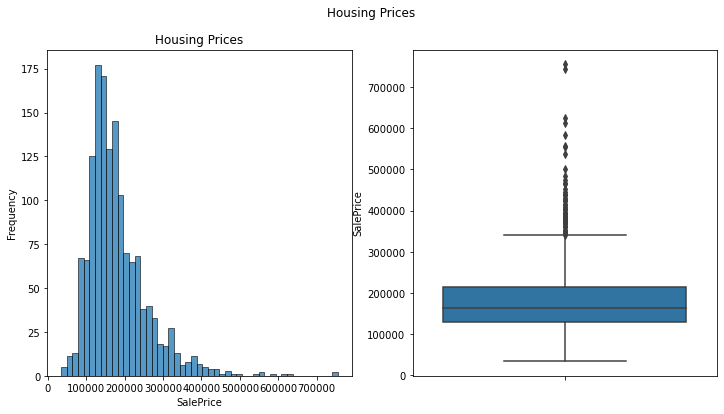

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
plt.suptitle('Housing Prices')
sns.histplot(x = train_y, ax = axs[0])
axs[0].set_xlabel('SalePrice')
axs[0].set_ylabel('Frequency')
sns.boxplot(y = train_y, ax = axs[1])
axs[1].set_ylabel('SalePrice')
axs[0].set_title('Housing Prices')
plt.show()

**Comments**

- Most houses are under 200,000. The median is around 160,000. The data is very positively skewed. The average house price is 180,000. The key will be to determine which features create the greatest spike in housing prices.

## EDA Functions <a class = "anchor" id = "edafunctions"></a>

[Back to top](#backtotop)

In [11]:
def plot_col_distributions(df, col_list = None, num_graph_cols = 4, figsize = (20, 20)):
    #Creating the column list
    if col_list is None:
        col_list = list(df.columns)
        
    #Determining the number of rows based on the number of columns.
    if len(col_list) % num_graph_cols == 0:
        num_rows = len(col_list) // num_graph_cols
    else:
        num_rows = (len(col_list) // num_graph_cols) + 1
    
    fig, axs = plt.subplots(num_rows, num_graph_cols, figsize = figsize)
    
    for idx, col in enumerate(col_list):
        #Determining the type of graph, based on the data type.
        if df[col].dtypes == float:
            graph_type = 'histplot'
        elif df[col].dtypes == object:
            graph_type = 'countplot'
        elif df[col].dtypes == int:
            if len(df[col].unique())>30:
                graph_type = 'histplot'
            else:
                graph_type = 'countplot'
                
        axs_idx = (idx// num_graph_cols, idx % num_graph_cols)
        
        #Creating each subplot
        if graph_type == 'countplot':
            sns.countplot(x = col, data =df, ax = axs[axs_idx], edgecolor = 'k')
        elif graph_type == 'histplot':
            sns.histplot(x = col, data = df, ax = axs[axs_idx], edgecolor = 'k')
        axs[axs_idx].set_xlabel(col)
        axs[axs_idx].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [12]:
def plot_col_vs_num_target(X, y, col_list = None, figsize = (20, 20), num_graph_cols = 4):
    #Creating the column list
    if col_list is None:
        col_list = list(X.columns)
        
    df = pd.concat([X, y], axis = 1)
    
    #Determining the number of rows of the subplot
    if len(col_list) % num_graph_cols == 0:
        num_rows = len(col_list) // num_graph_cols
    else:
        num_rows = (len(col_list) // num_graph_cols) + 1
        
    fig, axs = plt.subplots(num_rows, num_graph_cols, figsize = figsize)
    
    for idx, col in enumerate(col_list):
        #Determining the type of graph to use based on the data type.
        if df[col].dtypes == float:
            graph_type = 'regplot'
        elif df[col].dtypes == object:
            graph_type = 'boxplot'
        elif df[col].dtypes == int:
            graph_type = 'regplot'
            
        axs_idx = (idx// num_graph_cols, idx % num_graph_cols)
        
        #Plotting the data.
        if graph_type == 'boxplot':
            sns.boxplot(x = col, y = y.name, data = df, ax = axs[axs_idx])
        elif graph_type == 'regplot':
            sns.regplot(x = col, y = y.name, data = df, ax = axs[axs_idx])
        axs[axs_idx].set_xlabel(col)
        axs[axs_idx].set_ylabel('Sale Price')  
    plt.tight_layout()
    plt.show()

In [13]:
def check_quasi_constant_features(df, col_list = None):
    if col_list is None:
        [col for col in X.columns if X[col].dtypes == int or X[col].dtypes == object]    
    cat_name = []
    percentage = []
    for col in col_list:
        top_cat = df[col].value_counts(normalize = True).head(1)
        cat_name.append(top_cat.index[0])
        percentage.append(top_cat.values[0])
    return pd.DataFrame({'cat_name': cat_name, 
                         'percentage': percentage}, 
                        index = col_list).sort_values(by = 'percentage', ascending = False)

In [14]:
def corr_feat_target(X, y, col_list = None, figsize = (14, 6)):
    if col_list is None:
        col_list = [col for col in X.columns if X[col].dtypes == int or X[col].dtypes == float]
    plt.figure(figsize = figsize)
    df = pd.concat([X, y], axis = 1)
    df[col_list].corrwith(df[y.name]).plot(kind = 'bar', edgecolor = 'black')
    plt.title('Correlation between features and target')
    plt.ylabel('Correlation')
    plt.show()

## Object Features <a class = "anchor" id = "object"></a>

[Back to top](#backtotop)

### Constant/Quasi-constant Features <a class ="anchor" id = "constantobj"></a>

[Back to top](#backtotop)

In [15]:
obj_col_names = train_df.dtypes[train_df.dtypes == 'object'].index

In [16]:
check_quasi_constant_features(df = train_df, col_list = obj_col_names)

,cat_name,percentage
Utilities,AllPub,0.999315
Street,Pave,0.995890
Condition2,Norm,0.989726
RoofMatl,CompShg,0.982192
Heating,GasA,0.978082
GarageCond,TA,0.961566
GarageQual,TA,0.950689
LandSlope,Gtl,0.946575
CentralAir,Y,0.934932
Functional,Typ,0.931507


**Comments**

Drop columns where the largest category makes up 95% of the data.
- Utilities, Street, Condition2, RoofMatl, Heating, GarageCond, GarageQual

In [17]:
train_df.drop(['Utilities', 'Street', 'Condition2',
              'RoofMatl', 'Heating', 'GarageCond', 'GarageQual'], axis = 1, inplace = True)

### Distribution of Features <a class = "anchor" id = "distobjfeat"></a>

[Back to top](#backtotop)

In [18]:
#Redefine object columns (after columns have been dropped).
obj_col_names = train_df.dtypes[train_df.dtypes == 'object'].index

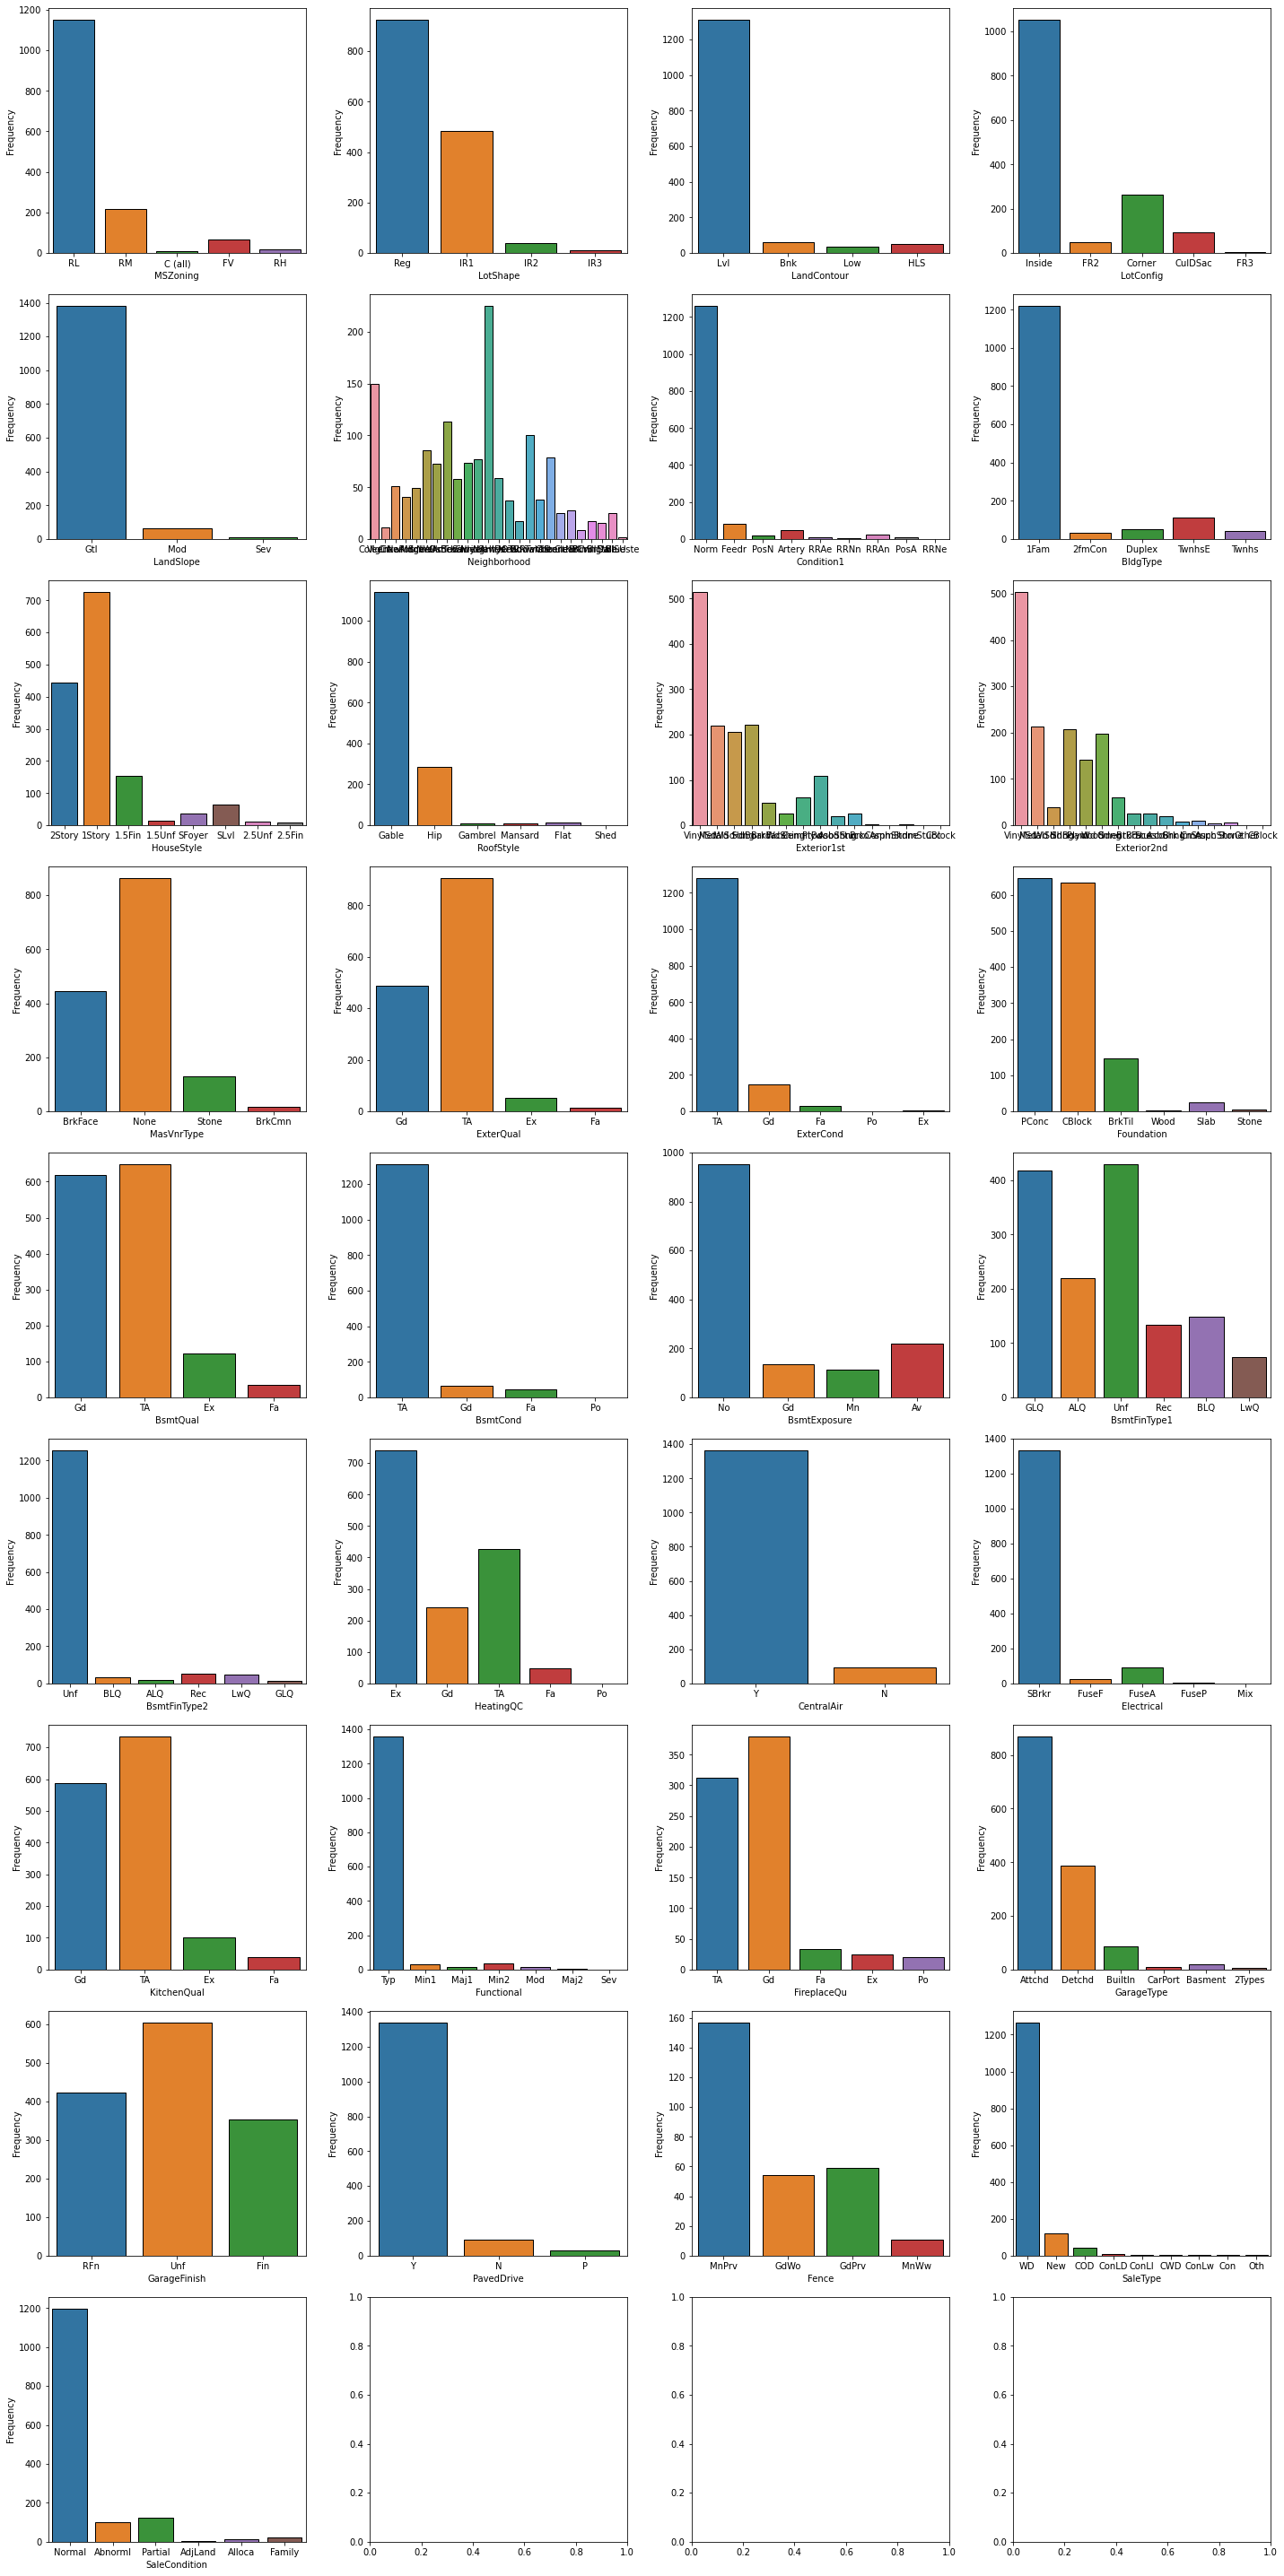

In [19]:
plot_col_distributions(df = train_df, col_list = obj_col_names, figsize = (20, 40))

**Comments**

- Fill null categorical columns with 'NA'

- Change condition and quality columns to ordinal variables.
    - Ex &rarr; 5
    - Gd &rarr; 4
    - TA &rarr; 3
    - Fa &rarr; 2
    - Po &rarr; 1
    - NA &rarr; 3 (will be filled with the middle value)

### Null Values <a class = "anchor" id = "fillnullobj"></a>

[Back to top](#backtotop)

In [20]:
for col in obj_col_names:
    train_df[col].fillna('NA', inplace = True)
    train_df[col].apply(lambda x: 'NA' if x == 'None' else x)

### Changing data from categorical to ordinal <a class = "anchor" id = "changedtypeobj"></a>

[Back to top](#backtotop)

In [21]:
cat_to_ordinal_dict = {'Ex':5 , 'Gd':4 , 'TA': 3, 'Fa': 2, 'Po':1, 'NA': 3}

In [22]:
cat_cols = train_df.columns[train_df.dtypes == 'object']
cat_to_ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                   'KitchenQual','FireplaceQu']

In [23]:
for col in cat_to_ord_cols:
    train_df[col] = train_df[col].apply(lambda x: cat_to_ordinal_dict[x] if x in cat_to_ordinal_dict.keys() else 3)

### Relationship between features and target <a class = "anchor" id = "objfeattarget"></a>

[Back to top](#backtotop)

In [24]:
new_cat_cols = train_df.columns[train_df.dtypes == 'object']

In [25]:
new_cat_cols

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir',
       'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive',
       'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

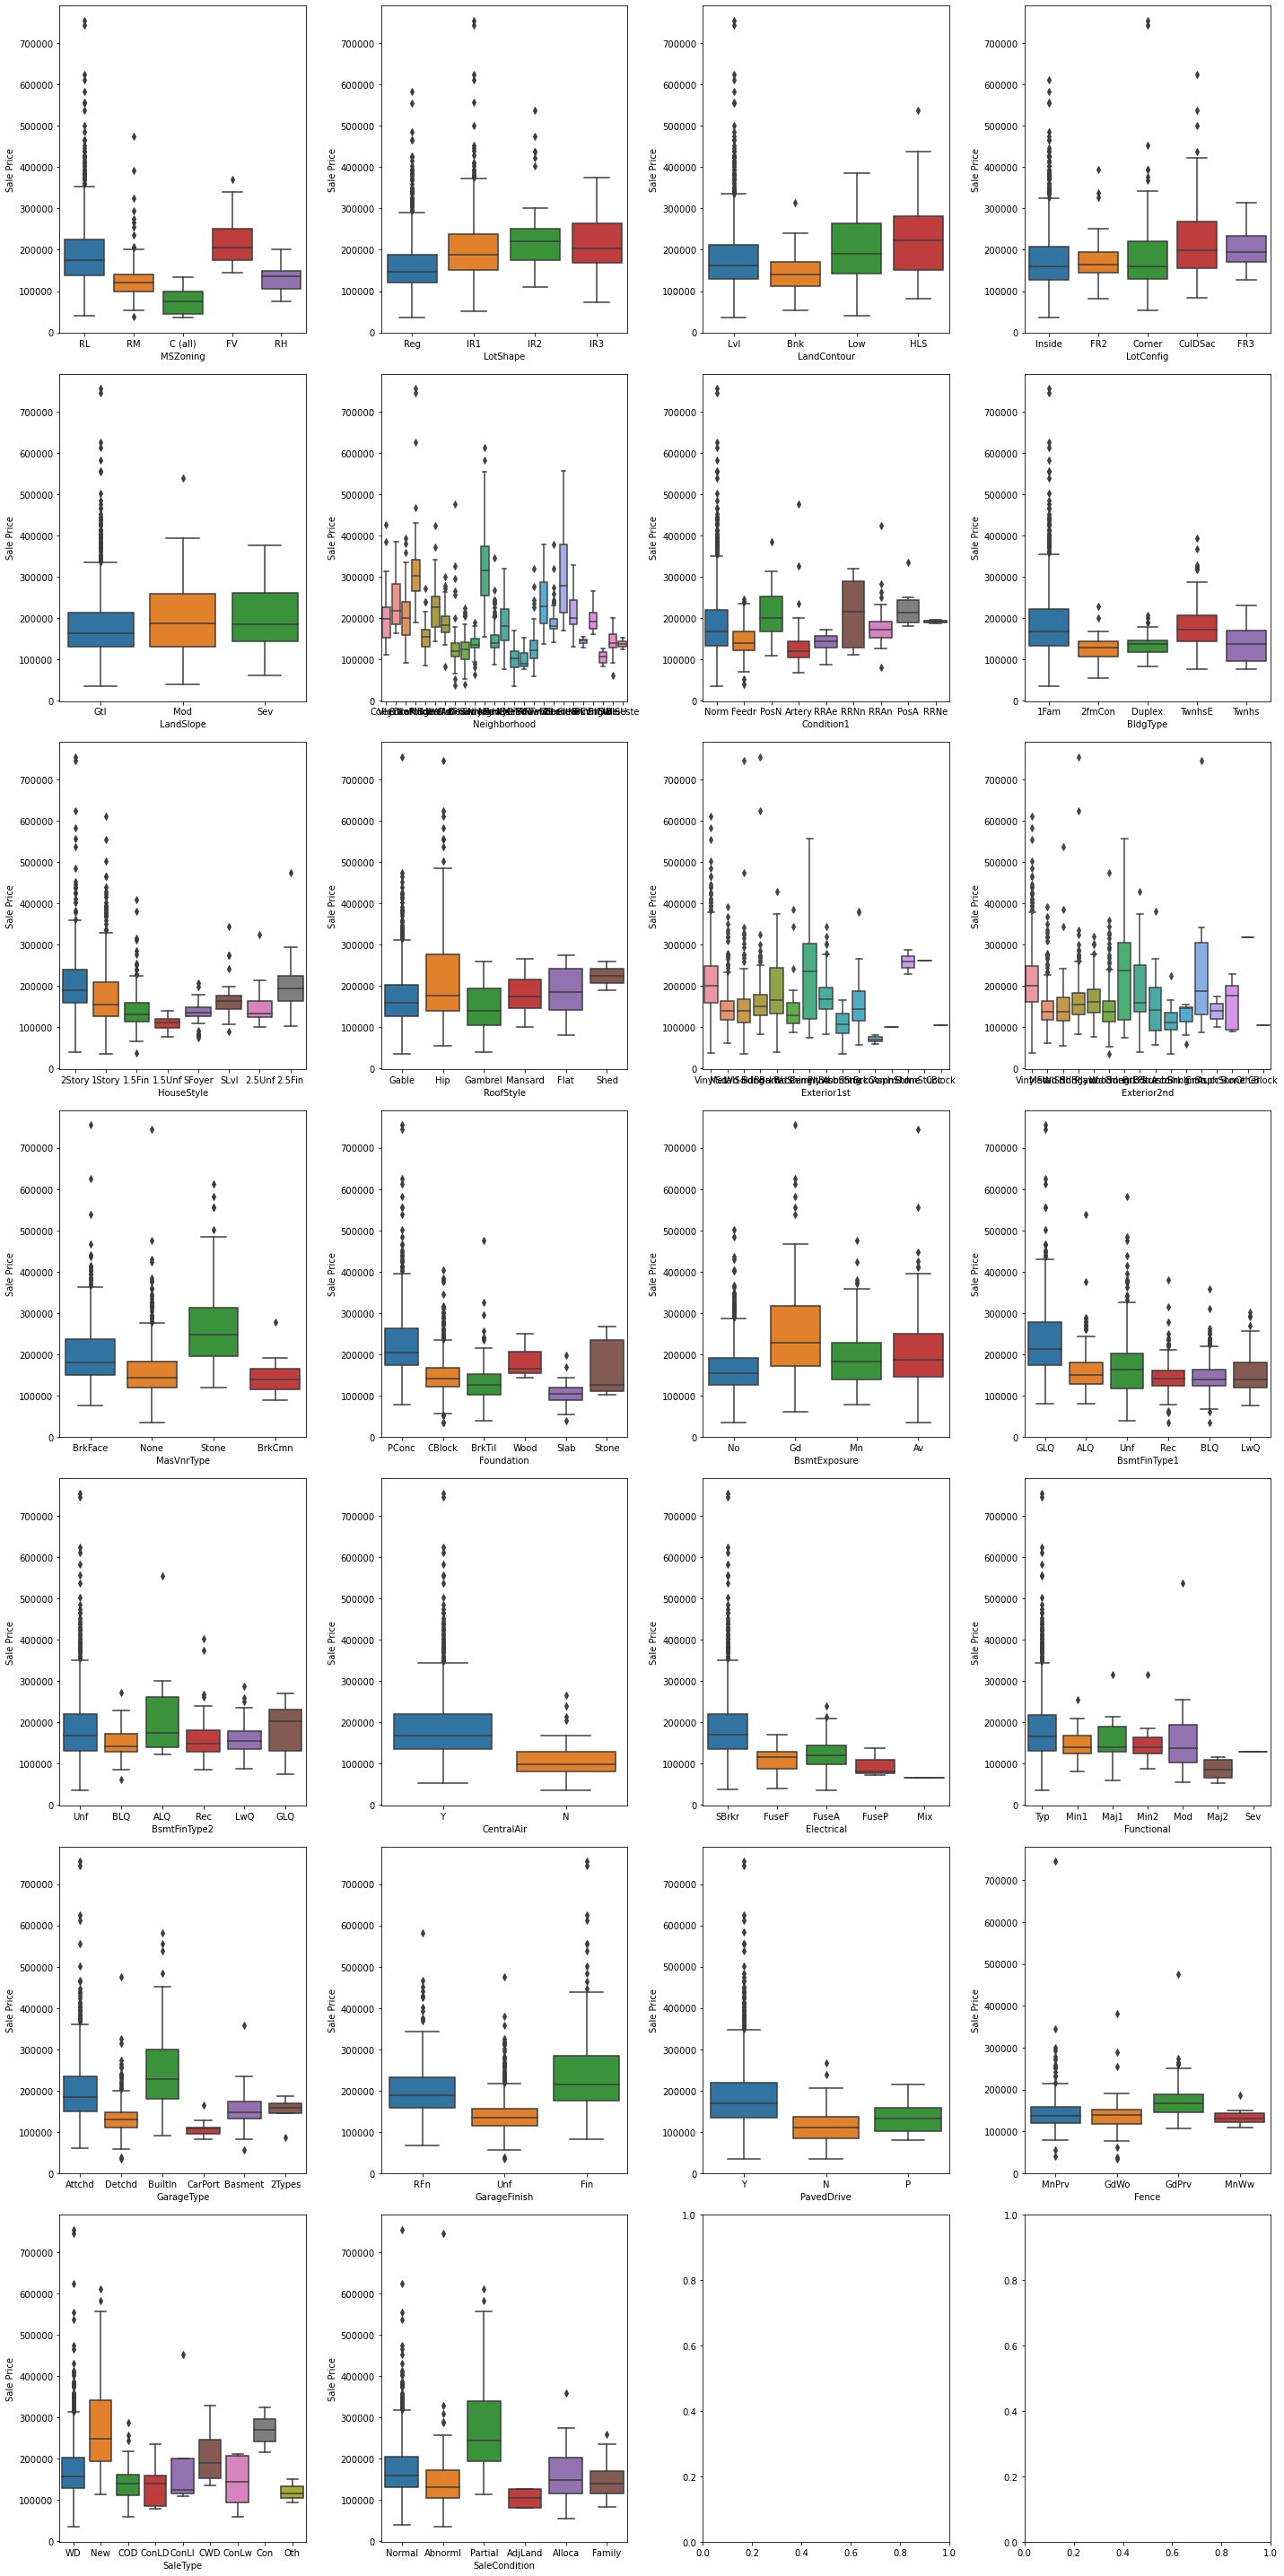

In [26]:
plot_col_vs_num_target(X = train_x, y = train_y, col_list = new_cat_cols, figsize = (20, 40))

**Comments**

- LandSlope does not seem to have much variation among the different categories. It is possible though that there is interaction between the variable and others instead of direct correlation with the target. Thus we will not drop it until looking at its feature importance later.
- Condition1 has a tail of low frequency categories. After analyzing the display of boxplots "Pos" categories and "RR" categories can be combined.
- RoofStyle has a tail of low frequency categories. Leave the two highest frequency categories. The others will be called "other'.
- Functional should be replaced with a binary variable. Either "Typ" or "Other".
- SaleType should be the first three categories and then "Other", even though there is some variance in the categories. This is because the categories are too small.
- Lastly, neighborhood seems to have the largest variance in price, so even though there are many categories, these will all be kept.

**Condition1**

In [27]:
train_df.Condition1.value_counts(normalize = True)

Norm      0.863014
Feedr     0.055479
Artery    0.032877
RRAn      0.017808
PosN      0.013014
RRAe      0.007534
PosA      0.005479
RRNn      0.003425
RRNe      0.001370
Name: Condition1, dtype: float64

In [28]:
train_df['Condition1'] = train_df.Condition1.apply(lambda x: 'RR' if 'RR' in x else ('Pos' if 'Pos' in x else x))

**RoofStyle**

In [29]:
train_df.RoofStyle.value_counts(normalize = True)

Gable      0.781507
Hip        0.195890
Flat       0.008904
Gambrel    0.007534
Mansard    0.004795
Shed       0.001370
Name: RoofStyle, dtype: float64

In [30]:
train_df['RoofStyle'] = train_df.RoofStyle.apply(lambda x: 'Other' if 'Gable' not in x and 'Hip' not in x else x)

**Functional**

In [31]:
train_df.Functional.value_counts(normalize = True)

Typ     0.931507
Min2    0.023288
Min1    0.021233
Mod     0.010274
Maj1    0.009589
Maj2    0.003425
Sev     0.000685
Name: Functional, dtype: float64

In [32]:
train_df['Functional'] = train_df.Functional.apply(lambda x: 'Other' if x != 'Typ' else x)

### Relationship between features <a class = "anchor" id = "objfeatrelationship"></a>

[Back to top](#backtotop)

In [33]:
var1 = ['LandContour', 'MasVnrType', 'BsmtCond',
       'LotShape']
var2 = ['LotConfig', 'ExterQual', 'BsmtExposure',
       'LotConfig']

In [34]:
for v1, v2 in zip(var1, var2):
    cont = pd.crosstab(train_df[v1], train_df[v2])
    print(f'Chi-squared test for independence between {v1} and {v2} p-value: {chi2_contingency(cont)[1]}\n')

Chi-squared test for independence between LandContour and LotConfig p-value: 0.005999601643317344

Chi-squared test for independence between MasVnrType and ExterQual p-value: 4.7495842936129416e-55

Chi-squared test for independence between BsmtCond and BsmtExposure p-value: 0.011305340730802492

Chi-squared test for independence between LotShape and LotConfig p-value: 1.7927706685590183e-41



**Comments**

- There seems to be dependence between the features, but it is risky to drop the features, without knowing which is more important. We will do this when checking feature importance.

## Numerical Features <a class = "anchor" id = "numerical"></a>

[Back to top](#backtotop)

### Integers Features <a class = "anchor" id = "integer"></a>

[Back to top](#backtotop)

In [35]:
int_col_names = train_df.columns[train_df.dtypes == 'int64']

In [36]:
int_col_names

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### Integer to Float

Columns that have area should be represented as float, not integer values for the purpose of EDA.
1. Columns with the word 'Area'
2. Columns with the word 'SF
3. Columns with the word 'Porch'

In [37]:
int_to_flt_cols = [x for x in int_col_names 
                   if 'Area' in x or 'SF' in x or 'Porch' in x]

In [38]:
train_df[int_to_flt_cols] = train_df[int_to_flt_cols].astype('float')

#### Constant/Quasi-constant Features <a class = "anchor" id = "constantint"></a>

[Back top top](#backtotop)

In [39]:
new_int_cols = train_df.drop(['SalePrice', 'Id'], axis = 1).columns[
    train_df.drop(['SalePrice', 'Id'], axis = 1).dtypes == 'int64']

In [40]:
new_int_cols

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageCars', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [41]:
check_quasi_constant_features(train_df, new_int_cols)

,cat_name,percentage
MiscVal,0,0.964384
KitchenAbvGr,1,0.953425
BsmtHalfBath,0,0.943836
BsmtCond,3,0.923288
ExterCond,3,0.878082
FireplaceQu,3,0.686986
HalfBath,0,0.625342
ExterQual,3,0.620548
BsmtFullBath,0,0.586301
GarageCars,2,0.564384


#### Integer columns distribution <a class = "anchor" id = "distintfeat"></a>

[Back to top](#backtotop)

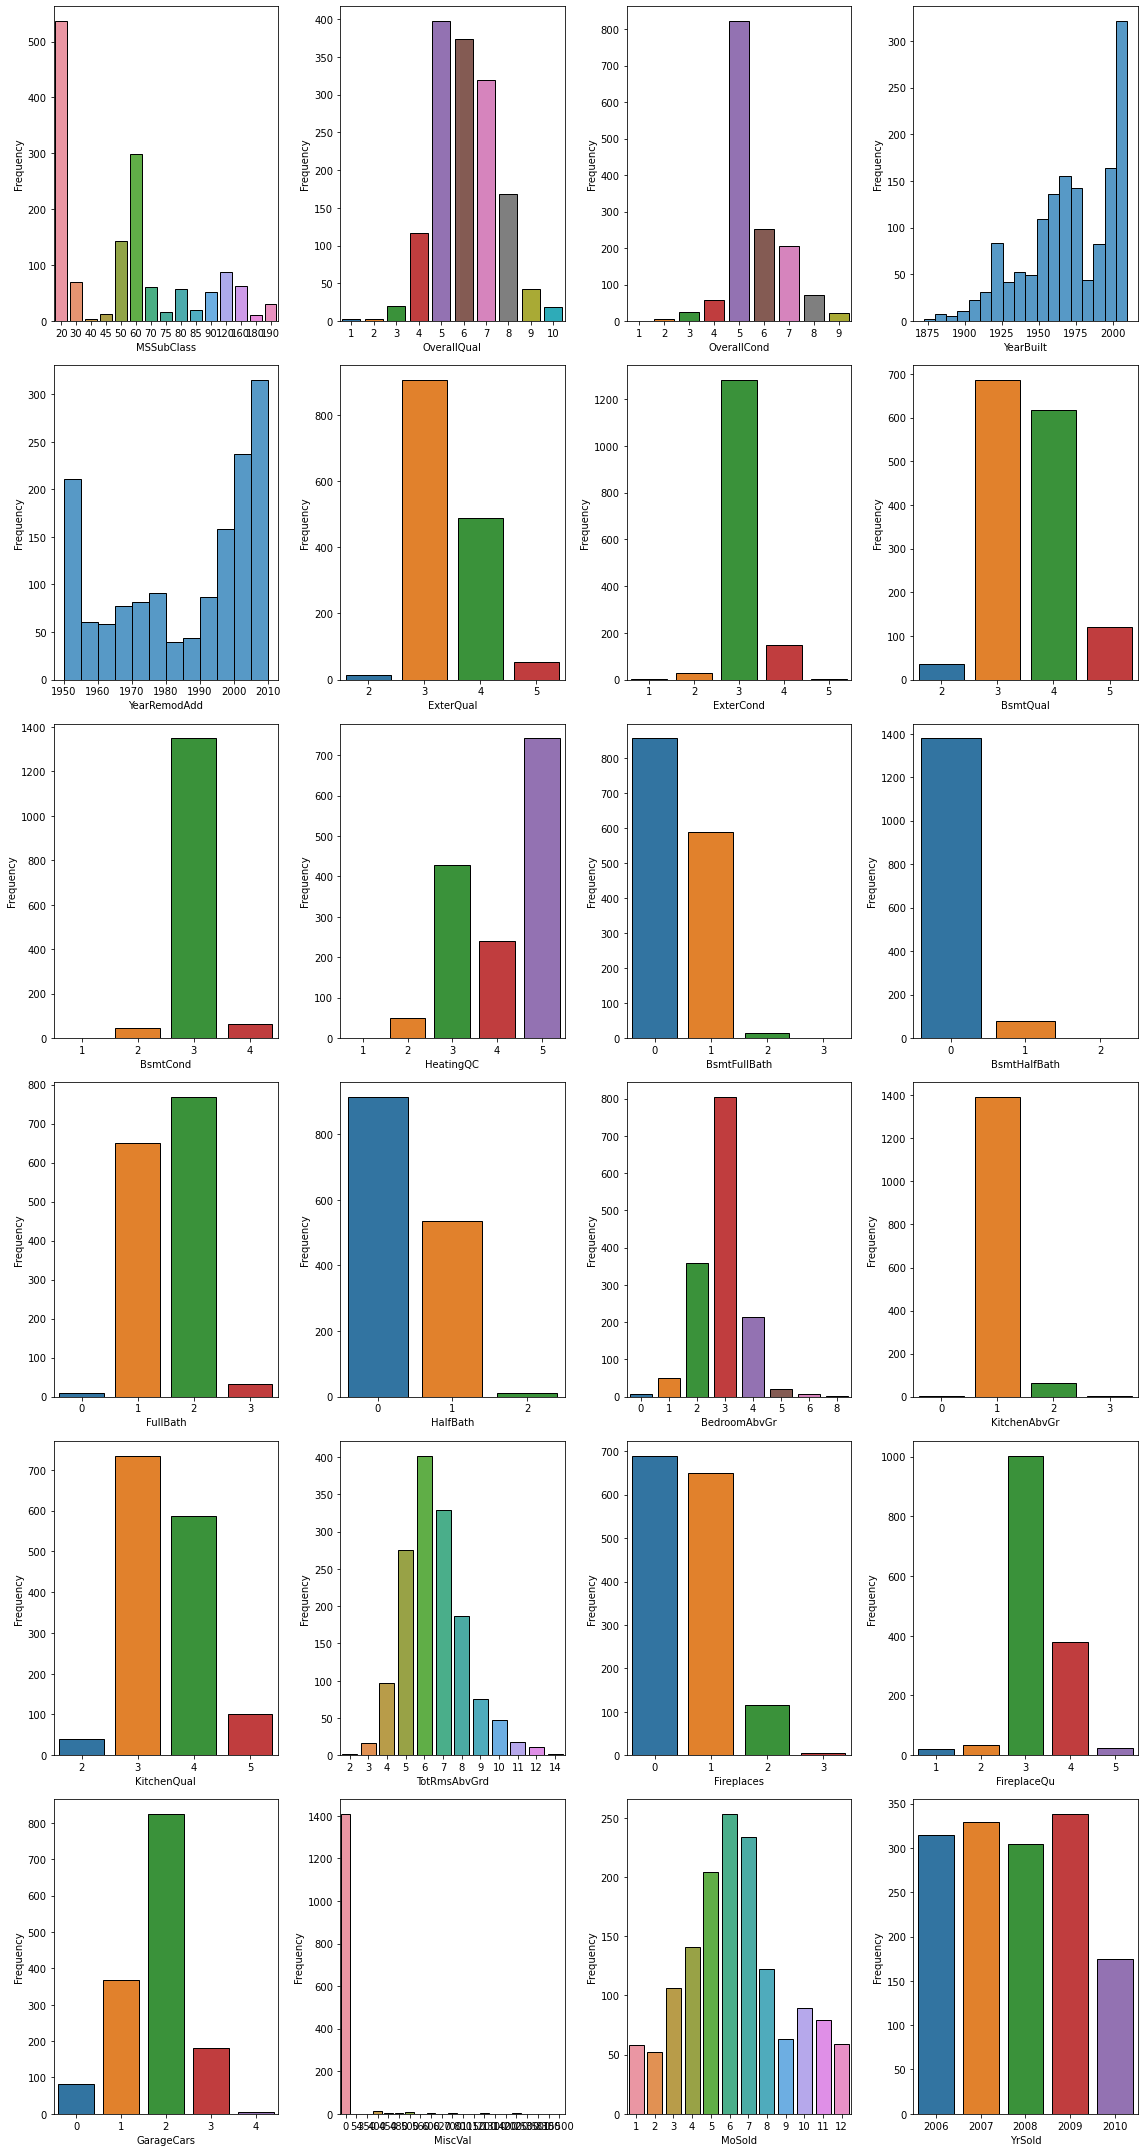

In [42]:
plot_col_distributions(df = train_df, col_list = new_int_cols, figsize = (16, 30))

**Comments**

- Drop the features with categories that make up over 95% of the data: 
    - [MiscVal and KitchenAbvGr]
- Overall condition/quality follow Gaussian Distributions.
- June was the most frequent month for home purchases.
- Houses were purchased evenly throughout the years. This column will remain though. Perhaps it is not correlated on its own with the target.
- Change MSSubClass to string
- Create a "building age" column
- Combine all of the bathrooms into one column

**Change MSSubClass to string**

In [43]:
train_df['MSSubClass'] = train_df['MSSubClass'].astype('str')

**Create a "RemodelAge" column**

In [44]:
train_df['RemodelAge'] = train_df.YearRemodAdd.max() - train_df.YearRemodAdd

**Combine all of the bathroom columns**

In [45]:
train_df['TotalBath'] = (train_df.BsmtFullBath + 
                         0.5*train_df.BsmtHalfBath +
                         train_df.FullBath + 
                         0.5 * train_df.HalfBath)

**Drop MiscVal, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath**

In [46]:
train_df.drop(['MiscVal', 'KitchenAbvGr', 'BsmtFullBath', 'YearRemodAdd',
               'BsmtHalfBath', 'FullBath', 'HalfBath'], axis = 1, inplace = True)

#### Correlation with the target <a class = "anchor" id = "intfeattarget"></a>

[Back to top](#backtotop)

In [47]:
new_int_cols = train_df.drop('Id', axis = 1).columns[train_df.drop('Id', axis = 1).dtypes == 'int']

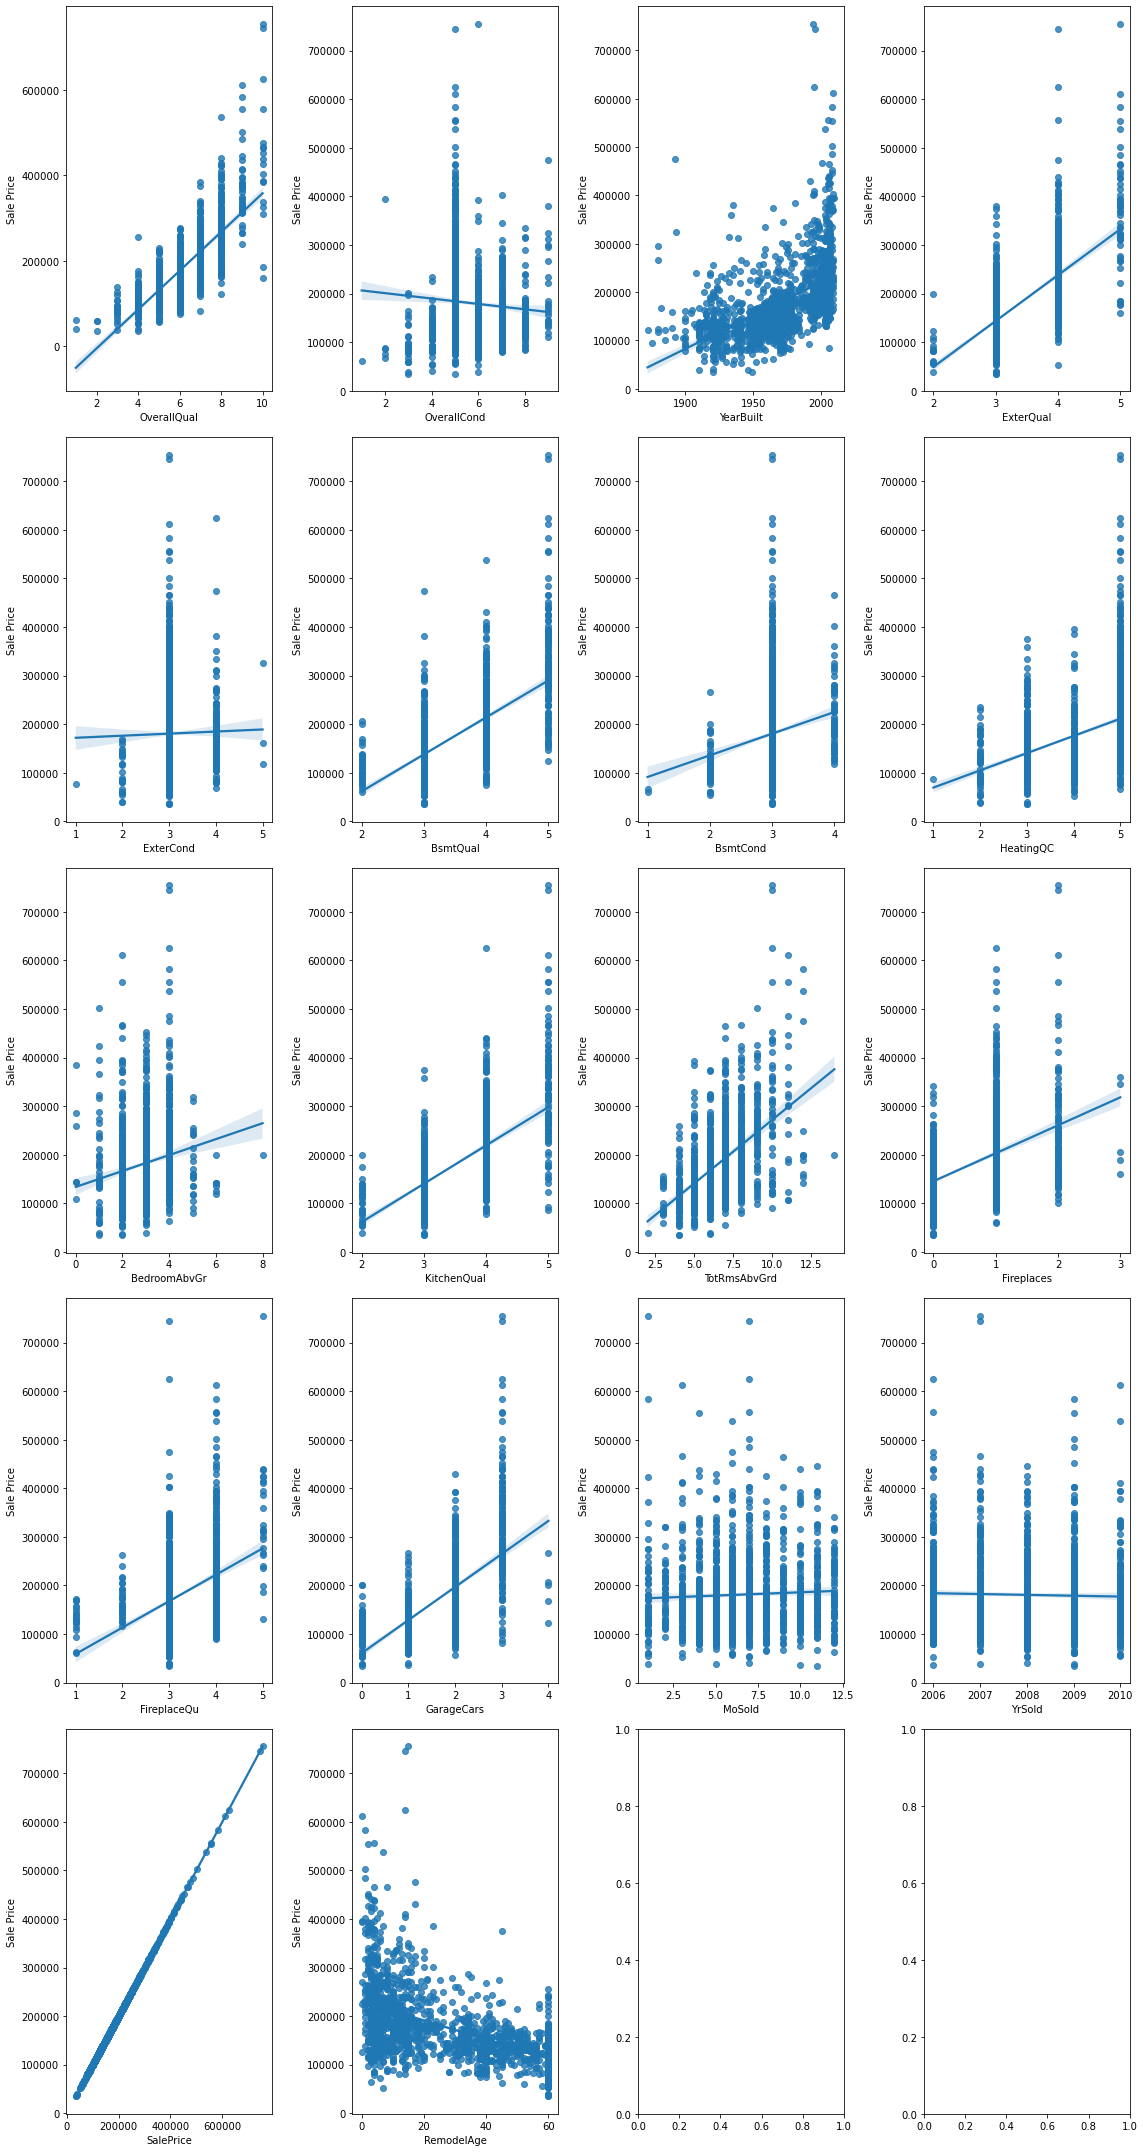

In [48]:
plot_col_vs_num_target(X = train_df.drop(['SalePrice'], axis = 1), 
                       y = train_df['SalePrice'], 
                       col_list = new_int_cols, 
                       figsize = (16, 30))

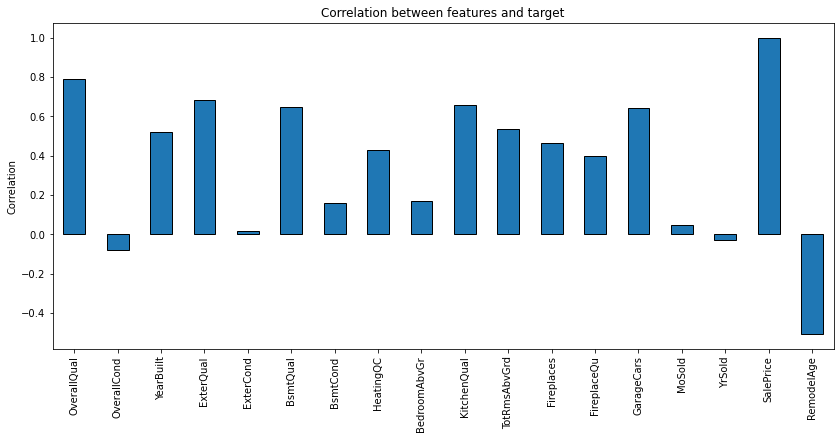

In [49]:
corr_feat_target(train_df.drop(['SalePrice'], axis = 1),train_df['SalePrice'], new_int_cols)

**Comments**
- It is not clear the distinction between overall quality and overall condition, but each has very different correlation to the target. We will add OverallCond to the "maybe drop" list because it is not very correlated to the target, and perhaps confuses the model.
- While month and year sold do not show correlation to price, these two variables will be kept. They will be changed to categorical variables, however, since the numerical value of the month and year does not actually carry its meaning (or hold a monotonic relationship to SalePrice).
- ExterCond also shows little correlation with price, whereas ExterQual does. ExterCond will be added to the potential drop list.

**Change MoSold to a categorical variable**

In [50]:
train_df['MoSold'] = train_df.MoSold.astype('str')
train_df['YrSold'] = train_df.YrSold.astype('str')

### Float Features <a class = "anchor" id = "float"></a>

[Back to top](#backtotop)

#### Features with Low Variance <a class = "anchor" id = "constantfloat"></a>

[Back to top](#backtotop)

In [51]:
float_col_names = train_df.dtypes[train_df.dtypes == 'float'].index

In [52]:
float_col_names

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'TotalBath'],
      dtype='object')

In [53]:
rel_variance = []
for col in float_col_names:
    rel_variance.append(train_df[col].var() / (train_df[col].max() - train_df[col].min()))

In [54]:
pd.Series(rel_variance, index = float_col_names).sort_values()

TotalBath          0.123370
3SsnPorch          1.691941
LotFrontage        2.019689
PoolArea           2.187285
LowQualFinSF       4.133224
GarageYrBlt        5.541659
ScreenPorch        6.476853
EnclosedPorch      6.767301
OpenPorchSF        8.025340
BsmtFinSF2        17.655297
WoodDeckSF        18.331171
MasVnrArea        20.490607
TotalBsmtSF       31.499568
GarageArea        32.237313
1stFlrSF          34.293272
BsmtFinSF1        36.857808
GrLivArea         52.021408
BsmtUnfSF         83.581509
2ndFlrSF          92.279455
LotArea          465.660098
dtype: float64

#### Float Columns Distribution <a class = "anchor" id = "distfloatfeat"></a>

[Back to top](#backtotop)

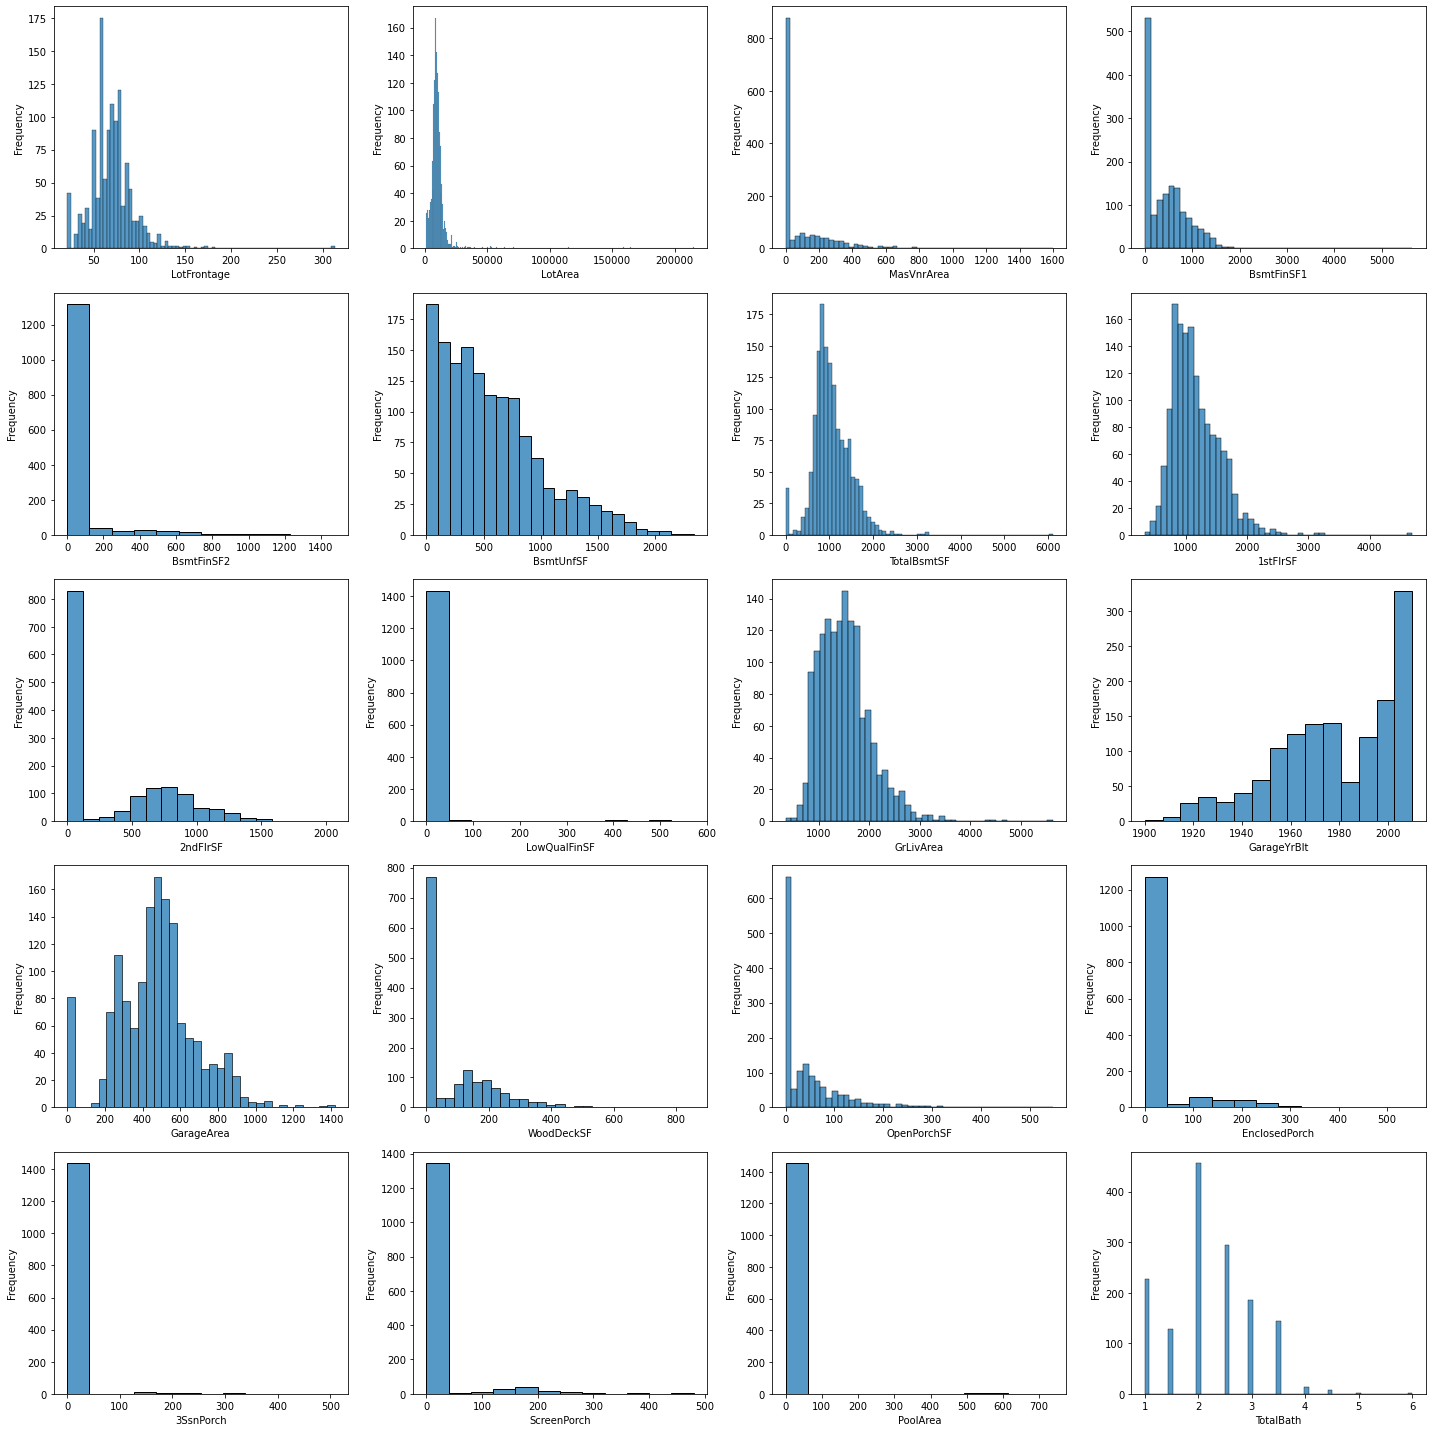

In [55]:
plot_col_distributions(df = train_df, col_list = float_col_names)

**Comments**

1. All the deck/porch variables are sparse. Perhaps it is best to combine these into a single variable for outdoor space. The correlation with the target is also weak as illustrated below. We will drop the individual variables.
2. PoolArea is almost Boolean as is, We will change this to a binary variable.

In [56]:
train_df['Pool'] = (train_df['PoolArea']>0)*1

In [57]:
outside_space_cols = [col for col in train_df.columns if 'Deck' in col or 'Porch' in col]

In [58]:
outside_space_cols

['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [59]:
train_df['outside_space'] = train_df[outside_space_cols].sum(axis = 1)

**Comments**
- Drop porch columns
- Remove BsmtFinSF1, BsmtFinSF2, and BsmtUnfSF, because TotalBsmtSF includes these values.
- Potentially remove 1stFlrSF and 2ndFlrSF because GrLivArea includes this.

In [60]:
train_df.drop(outside_space_cols, axis = 1, inplace = True)

In [61]:
train_df.drop(['PoolArea'], axis = 1, inplace = True)

In [62]:
train_df.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis = 1, inplace = True)

In [63]:
train_df.drop(['1stFlrSF', '2ndFlrSF'], axis = 1, inplace = True)

### Correlation Between Numerical Features and Target <a class = "anchor" id = "correlation"></a>

[Back to top](#backtotop)

In [64]:
num_cols = train_df.columns[train_df.dtypes != 'object']

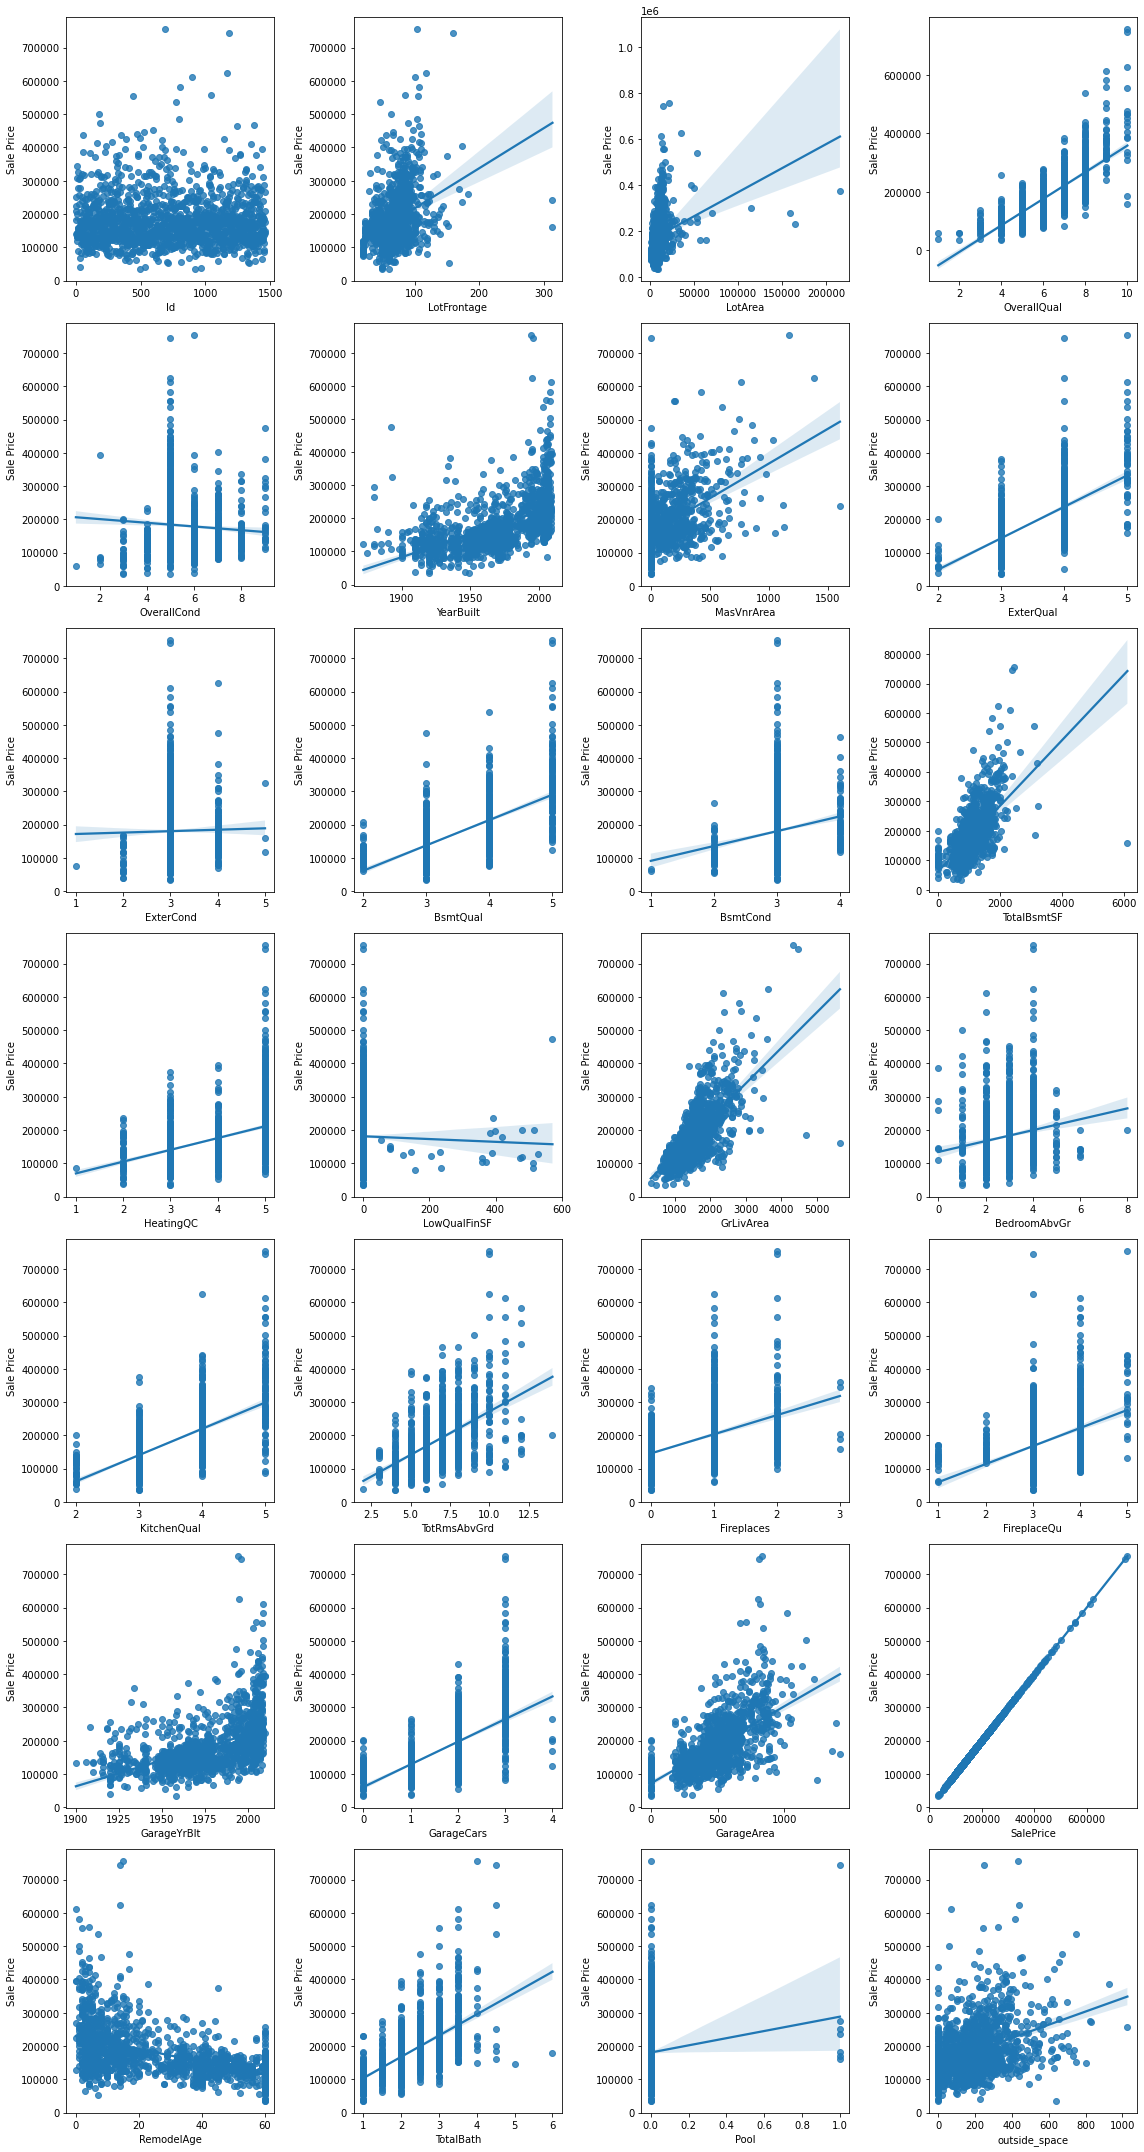

In [65]:
plot_col_vs_num_target(X = train_df.drop(['SalePrice'], axis = 1), 
                       y = train_df['SalePrice'], 
                       col_list = num_cols, 
                       figsize = (16, 30))

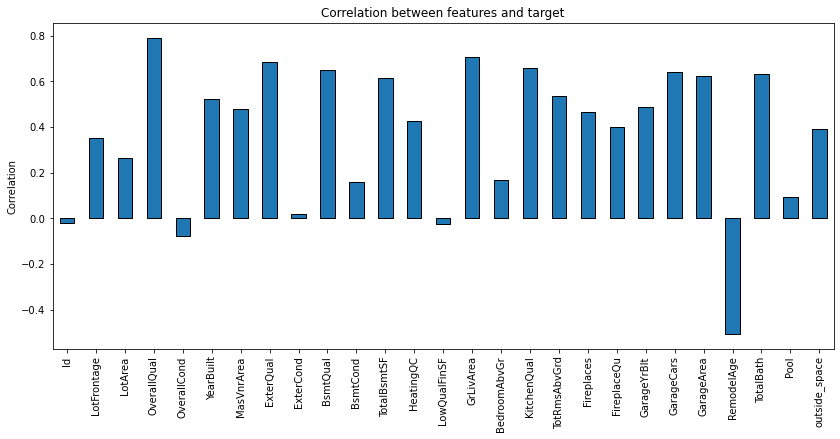

In [66]:
corr_feat_target(train_df.drop(['SalePrice'], axis = 1),train_df['SalePrice'])

**Comments**
- Potentially drop LowQualFinSF and ExterCond from the list, though it may be best to leave these to feature importance.

### Correlation Between Numerical Features <a class = "anchor" id = "btwnfeatures"></a>

[Back to top](#backtotop)

In [67]:
def correlation_matrix(df, col_list = None, figsize = (24, 20)):
    '''
    This function takes the DataFrame of features and outputs an lower triangle correlation heatmap.
    
    df: Pandas DataFrame of features.
    
    col_list: List of columns to plot. Default is set to None, and in this case, all the integer and object columns are considered.
    
    figsize: Tuple of integer dimensions for the size of the figure.
    '''
    if col_list is None:
        col_list = [col for col in df.columns if df[col].dtypes == int or df[col].dtypes == float]
    plt.figure(figsize = figsize)
    mask = np.triu(np.ones_like(df[col_list].corr()))
    sns.heatmap(df[col_list].corr(), annot = True, mask = mask)

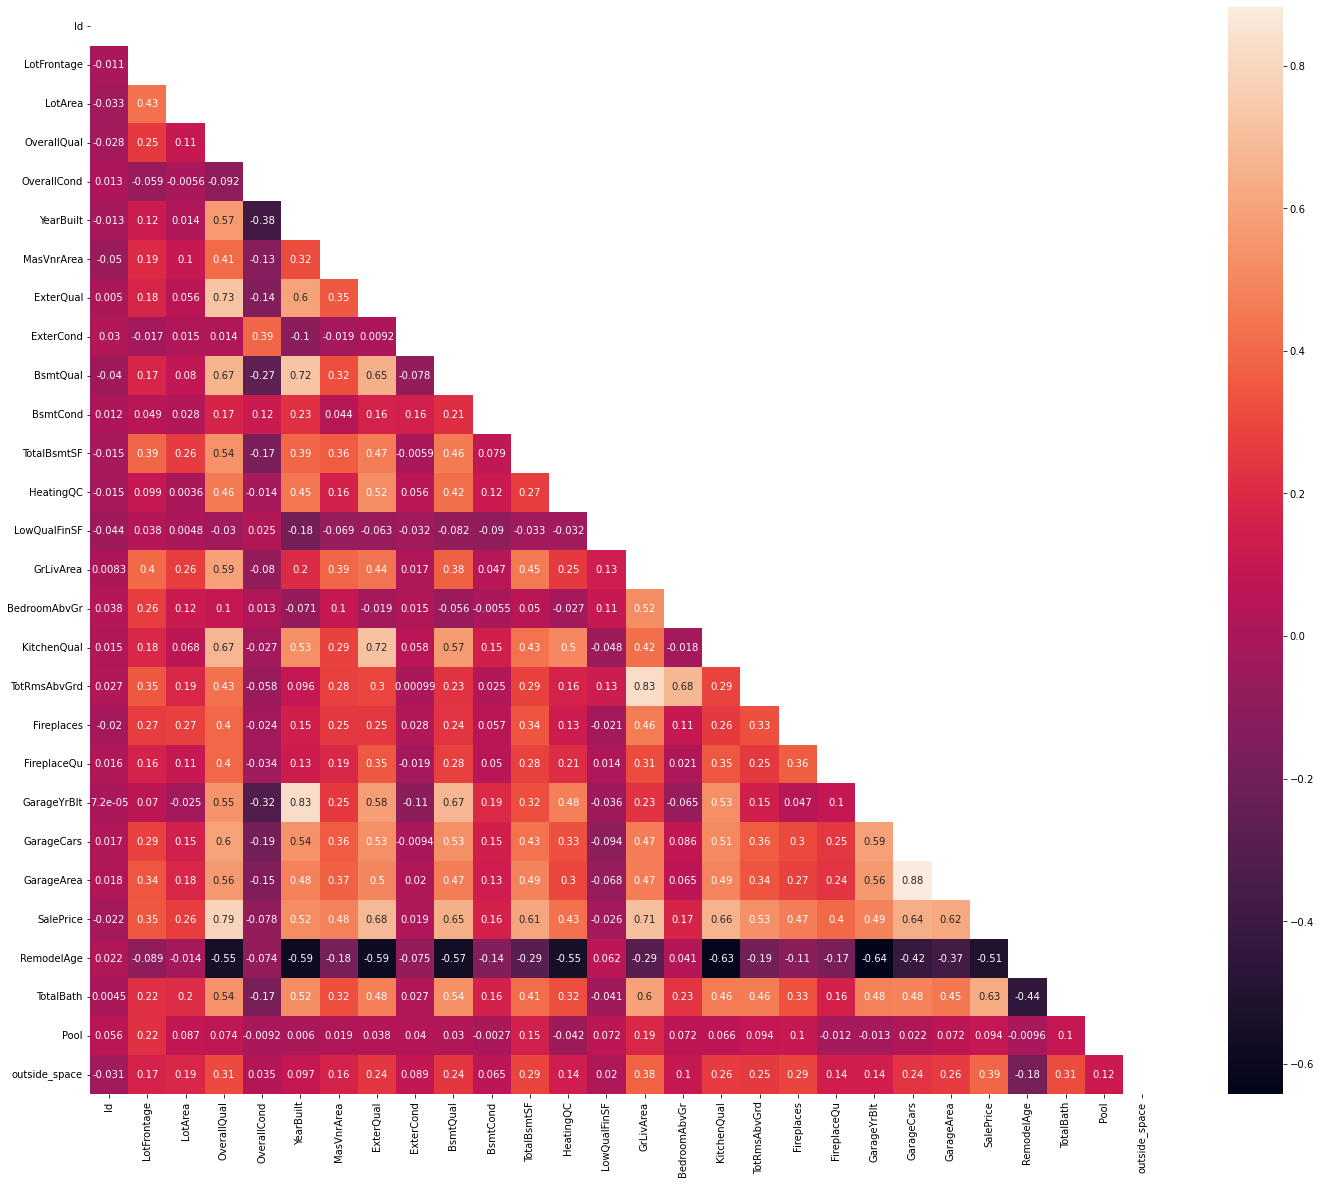

In [68]:
correlation_matrix(train_df, figsize = (24, 20))

### Drop Correlated Features <a class = "anchor" id = "dropcorr"></a>

[Back to top](#backtotop)

In [69]:
train_df[num_cols].corr().unstack().abs()[train_df[num_cols].corr().unstack().abs().sort_values() != 1].sort_values(ascending = False).head(20)

GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
TotRmsAbvGrd  GrLivArea       0.825489
GrLivArea     TotRmsAbvGrd    0.825489
SalePrice     OverallQual     0.790982
OverallQual   SalePrice       0.790982
              ExterQual       0.726278
ExterQual     OverallQual     0.726278
BsmtQual      YearBuilt       0.724570
YearBuilt     BsmtQual        0.724570
KitchenQual   ExterQual       0.716122
ExterQual     KitchenQual     0.716122
SalePrice     GrLivArea       0.708624
GrLivArea     SalePrice       0.708624
SalePrice     ExterQual       0.682639
ExterQual     SalePrice       0.682639
TotRmsAbvGrd  BedroomAbvGr    0.676620
BedroomAbvGr  TotRmsAbvGrd    0.676620
dtype: float64

In [70]:
train_df[['SalePrice', 'GarageCars', 'GarageArea']].corr()

,SalePrice,GarageCars,GarageArea
SalePrice,1.000000,0.640409,0.623431
GarageCars,0.640409,1.000000,0.882475
GarageArea,0.623431,0.882475,1.000000


In [71]:
train_df[['SalePrice','Fireplaces', 'FireplaceQu']].corr()

,SalePrice,Fireplaces,FireplaceQu
SalePrice,1.000000,0.466929,0.401053
Fireplaces,0.466929,1.000000,0.364760
FireplaceQu,0.401053,0.364760,1.000000


**Comments**
- Drop GarageArea, because GarageCars and GarageArea are highly correlated to each other and GarageCars has a higher correlation with the target.
- Make Fireplace a boolean variable.
- Drop GarageYrBlt as this is highly correlated to the year that the house was built.

In [72]:
train_df.drop(['GarageArea'], axis = 1, inplace = True)

In [73]:
train_df['Fireplace'] = (train_df['Fireplaces'] > 0)*1

In [74]:
train_df.drop(['Fireplaces', 'FireplaceQu'], axis = 1, inplace = True)

In [75]:
train_df.drop(['GarageYrBlt'], axis = 1, inplace = True)

## Imputing Null Values <a class = "anchor" id = "imputing"></a>

[Back to top](#backtotop)

In [76]:
train_df.isna().mean().sort_values(ascending = False)

LotFrontage      0.177397
MasVnrArea       0.005479
Id               0.000000
GarageFinish     0.000000
HeatingQC        0.000000
CentralAir       0.000000
Electrical       0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
BedroomAbvGr     0.000000
KitchenQual      0.000000
TotRmsAbvGrd     0.000000
Functional       0.000000
GarageType       0.000000
GarageCars       0.000000
BsmtFinType2     0.000000
PavedDrive       0.000000
Fence            0.000000
MoSold           0.000000
YrSold           0.000000
SaleType         0.000000
SaleCondition    0.000000
SalePrice        0.000000
RemodelAge       0.000000
TotalBath        0.000000
Pool             0.000000
outside_space    0.000000
TotalBsmtSF      0.000000
BsmtFinType1     0.000000
MSSubClass       0.000000
OverallQual      0.000000
MSZoning         0.000000
LotArea          0.000000
LotShape         0.000000
LandContour      0.000000
LotConfig        0.000000
LandSlope        0.000000
Neighborhood     0.000000
Condition1  

**LotFrontage**

In [77]:
train_df.corr()['LotFrontage'].abs().sort_values(ascending = False).head(5)

LotFrontage     1.000000
LotArea         0.426095
GrLivArea       0.402797
TotalBsmtSF     0.392075
TotRmsAbvGrd    0.352096
Name: LotFrontage, dtype: float64

**Comments**
- LotFrontage is somewhat correlated to LotArea, so we can impute the values with the mean of the LotFrontage in a bin for LotArea that is the same.

In [78]:
_, first_floor_bins = pd.qcut(train_df['LotArea'], 20, retbins = True)

In [79]:
train_df['lot_area_bins'] = pd.cut(train_df['LotArea'], bins = first_floor_bins)

In [80]:
lot_frontage_miss_dict = train_df.groupby('lot_area_bins')['LotFrontage'].mean().to_dict()

In [81]:
train_df.loc[train_df['LotFrontage'].isna(), 'LotFrontage'] = train_df.loc[train_df.LotFrontage.isna()].apply(lambda x: lot_frontage_miss_dict[x['lot_area_bins']], axis = 1)

**MasVnrArea**

In [82]:
train_df.corr()['MasVnrArea'].abs().sort_values(ascending = False).head(5)

MasVnrArea     1.000000
SalePrice      0.477493
OverallQual    0.411876
GrLivArea      0.390857
GarageCars     0.364204
Name: MasVnrArea, dtype: float64

In [83]:
train_df['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

- It looks like the most common value is 0, we will impute the null value with 0.

# Pre-processing Classes <a class="anchor" id="preprocessing"></a>

[Back to top](#backtotop)

- Columns to drop: [PoolQC, MiscFeature, Alley, Utilities, Street, Condition2, RoofMatl, Heating, GarageCond, GarageQual,
MiscVal, KitchenAbvGr, GarageArea, FireplaceQu, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF]

- Columns to potentially drop: [1stFlrSF, 2ndFlrSF, LowQualFinSF, GarageArea, GarageYrBlt]

- Columns to Add:
    - RemodelAge: YearRemodAdd 
    - TotalBath: BsmtFullBath, BsmtHalfBath, FullBath, HalfBath 
    - outside_space: WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch
    - Pool: PoolArea
    - FirePlace: Fireplaces
    
    
- Columns to Drop After Adding: [BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, YearRemodAdd, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fireplaces]

- Column types to change in Pipeline:
    - Categorical to ordinal: 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'FireplaceQu'
    - Integer to float: Columns with the word 'Area', Columns with the word 'SF, Columns with the word 'Porch'
    - Int to cat: MSSubClass, MoSold, YrSold

- Filling values in Pipeline:
    - Categorical as "NA"
    - LotFrontage is somewhat correlated to 1stFlrSF, so we can impute the values with the mean of the LotFrontage in a bin for 1stFlrSF that is the same.
    - In 75% of the cases, the garage is built in the same year as the house. It is possible to impute with this value. Though it is also possible that the house does not contain a garage at all.
    - It looks like the most common value is 0, we will impute the null value with 0.

In [84]:
cat_to_ord = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                'KitchenQual', 'GarageQual', 'GarageCond', 'FireplaceQu']

In [85]:
sklearn_columns_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'GarageCond',
                'GarageQual','MiscVal', 'KitchenAbvGr', 'GarageArea', 'FireplaceQu', 'GarageYrBlt',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']

In [86]:
# cols_drop_maybe = ['LandSlope', 'OverallCond', 'ExterCond',
#                    'LotShape', 'LotConfig', 'LandSlope', 'LandContour', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']

In [87]:
class sklearn_pre_processor(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols, cat_to_ord_cols):
        self.drop_cols = drop_cols
        self.cat_to_ord_cols = cat_to_ord_cols
    
    def fit(self, X, y):
        #Defining category columns based on the training data
        self.train_x = X
        self.cat_cols = X.columns[X.dtypes == 'object']
        
        #Defining int cols
        self.int_cols = X.columns[X.dtypes == 'int']

        #Defining cols to change
        self.cat_to_ordinal_dict = {'Ex':5 , 'Gd':4 , 'TA': 3, 'Fa': 2, 'Po':1, 'NA': -1}

        #Creating numerical column fill dictionaries
        #1stFlrSF
        _, self.first_floor_bins = pd.qcut(train_df['1stFlrSF'], 10, retbins = True)
        self.lot_frontage_miss_dict = X.groupby(pd.cut(X['1stFlrSF'], bins = self.first_floor_bins))['LotFrontage'].mean().to_dict()

        #Save Max Year Model Add
        self.YearRemodAddMax = X.YearRemodAdd.max()

        #Saving outside space columns
        self.outside_space_cols = [col for col in X.columns if 'Deck' in col or 'Porch' in col]

        #Additional Drop Columns
        self.additional_drop_cols = []
        
        return self
        
    def transform(self, X):
        processed_X = X.set_index('Id').copy()

        #Fill Null Values in Cat Columns
        for col in self.cat_cols:
            processed_X[col].fillna('NA', inplace = True)
            processed_X[col] = processed_X[col].apply(lambda x: 'NA' if x == 'None' else x)

        #Add columns
        #YearBult
        processed_X['YearBuilt'] = processed_X['YearBuilt'].fillna(self.train_x.YearBuilt.median())
        #RemodelAge
        processed_X.loc[processed_X.YearRemodAdd.isna(), 'YearRemodAdd'] = processed_X.loc[processed_X.YearRemodAdd.isna(), 'YearBuilt']
        processed_X['RemodelAge'] = self.YearRemodAddMax- processed_X.YearRemodAdd
        self.additional_drop_cols += ['YearRemodAdd']

        #TotalBath
        processed_X['TotalBath'] = (processed_X.BsmtFullBath.fillna(0) + 
                                    0.5*processed_X.BsmtHalfBath.fillna(0) +
                                    processed_X.FullBath.fillna(0) + 
                                    0.5 * processed_X.HalfBath.fillna(0))
        
        self.additional_drop_cols += ['BsmtFullBath', 'BsmtHalfBath',
                                     'FullBath', 'HalfBath']

        #Outside Space
        for col in self.outside_space_cols:
            processed_X[col] = processed_X[col].fillna(0)
            
        processed_X['outside_space'] = processed_X[self.outside_space_cols].sum(axis = 1)
        self.additional_drop_cols += self.outside_space_cols

        #Pool
        processed_X['Pool'] = (processed_X['PoolArea']>0)*1
        self.additional_drop_cols += ['PoolArea']
        
        #Fireplace
        processed_X['Fireplace'] = (processed_X['Fireplaces']>0)*1
        self.additional_drop_cols += ['Fireplaces']

        #Change data types
        for col in self.cat_to_ord_cols:
            processed_X[col] = processed_X[col].apply(lambda x: self.cat_to_ordinal_dict[x] if x in self.cat_to_ordinal_dict.keys() else -1)

        processed_X['MSSubClass'] = processed_X['MSSubClass'].astype(object)
        processed_X['MoSold'] = processed_X['MoSold'].astype(object)
        processed_X['YrSold'] = processed_X['YrSold'].astype(object)

        #Filling missing values
        #Categorical columns
        cat_cols = [col for col in processed_X.columns if processed_X[col].dtypes == object]
        processed_X[col].fillna('NA')
        
        #Fill with median columns
        median_cols = ['OverallCond', 'YearBuilt', 'LotFrontage', 'LotArea', 'TotalBsmtSF',
                      'GrLivArea', 'OverallQual', 'TotRmsAbvGrd', 'BedroomAbvGr']
        for col in median_cols:
            processed_X[col] = processed_X[col].fillna(self.train_x[col].median())
    
        #Fill with 0 Columns
        for col in ['GarageCars', 'LowQualFinSF', 'MasVnrArea']:
            processed_X[col] = processed_X[col].fillna(0)
            
        #SF columns
        for col in [x for x in processed_X.columns if 'SF' in x]:
            processed_X[col] = processed_X[col].fillna(0)
        
        #LotFrontage
        processed_X['1st_flr_bins'] = pd.cut(processed_X['1stFlrSF'], bins = self.first_floor_bins)
        processed_X.loc[processed_X['LotFrontage'].isna(), 'LotFrontage'] = (processed_X.loc[processed_X.LotFrontage.isna()]
                                                                             .apply(lambda x: self.lot_frontage_miss_dict[x['1st_flr_bins']], axis = 1))
        self.additional_drop_cols += ['1st_flr_bins']
        
        #GarageYrBlt
        processed_X.loc[processed_X.GarageYrBlt.isna(), 'GarageYrBlt'] = processed_X.loc[processed_X.GarageYrBlt.isna(), 'YearBuilt']                                                            
        
        #Reducing Columns
        #Condition1
        processed_X['Condition1'] = processed_X.Condition1.apply(lambda x: 'RR' if 'RR' in x else ('Pos' if 'Pos' in x else x))
        #RoofStyle
        processed_X['RoofStyle'] = processed_X.RoofStyle.apply(lambda x: 'Other' if 'Gable' not in x and 'Hip' not in x else x)
        #Functional
        processed_X['Functional'] = processed_X.Functional.apply(lambda x: 'Other' if x != 'Typ' else x)
        
        #Drop General Columns
        processed_X.drop(self.drop_cols, axis = 1, inplace = True)
        
        #Drop Additional Columns
        processed_X.drop(self.additional_drop_cols, axis = 1, inplace = True)
        return processed_X

In [88]:
class NumericalScaler(BaseEstimator, TransformerMixin):
    def __init__(self, method = 'min_max_scaling', col_list = None, inplace = False):
        '''
        method: Either 'min_max_scaling' or 'standardization'. Default is 'min_max_scaling'.
        
        col_list: List of column names to be transformed. Default is 'None', which means that all numerical columns are taken into consideration.
        
        inplace: True/False. Default value is False, and in this case the original DataFrame is not overwritten. When inplace is set to True, the original DataFrame is overwritten.
        '''
        self.inplace = inplace
        self.col_list = col_list
        self.method = method
        
    def fit(self, X, y):
        '''
        A function that fits the scaler to the values in the training data.
        
        X: A Series or DataFrame of features.
        
        y: A Series of y-values.
        '''
        self.num_col_dict = {}
        if type(X) == pd.core.series.Series:
            self.type = 'Series'
            X = X.to_frame()
        else:
            self.type = 'DataFrame'
        if self.col_list is None: 
            self.num_cols = [col for col in X.columns if X[col].dtypes == int]
            self.num_cols += [col for col in X.columns if X[col].dtypes == float]
        else:
            if type(self.col_list) != list:
                raise ValueError('col_list must be entered as a list of strings')
            self.num_cols = self.col_list
        if self.method == 'min_max_scaling':
            for col in self.num_cols:
                parameters = {}
                parameters['min'] = X[col].min()
                parameters['max'] = X[col].max()
                self.num_col_dict[col] = parameters
        elif self.method == 'standardization':
            for col in self.num_cols:
                parameters = {}
                parameters['mean'] = X[col].mean()
                parameters['stdev'] = X[col].std()
                self.num_col_dict[col] = parameters
        else:
            raise ValueWarning('Valid methods are min_max_scaling or standardization')
        return self
    
    def transform(self, X):
        '''
        A function that transforms the variables in the DataFrame, based on the parameters from the train set.
        
        X: A DataFrame of features.
        
        returns: A transformed DataFrame of features.
        '''
        if self.inplace:
            transformed_df = X
        else:
            transformed_df = X.copy()
        if self.type == 'Series':
            transformed_df = transformed_df.to_frame()
        if self.method == 'min_max_scaling':
            for col in self.num_cols:
                parameters = self.num_col_dict[col]
                transformed_df[col] = (transformed_df[col] - parameters['min'])/(parameters['max'] - parameters['min'])
        else:
            for col in self.num_cols:
                parameters = self.num_col_dict[col]
                transformed_df[col] = (transformed_df[col] - parameters['mean'])/ (parameters['stdev'])
        if self.type == 'Series':
            transformed_df = transformed_df[self.num_cols[0]]
        return transformed_df
    
    def inverse_transform(self, X):
        '''
        A function that reverses the process of scaling on the features in the DataFrame X.
        
        X: A DataFrame of features.
        
        returns: A reverse transformed DataFrame of features.
        '''
        if self.inplace:
            inv_transformed_df = X
        else:
            inv_transformed_df = df.copy()
        if self.col_list is None:
            self.col_list = self.num_cols
        if type(self.col_list) != list:
            raise ValueWarning('col_list must be given as a list of column names.')
        if self.method == 'min_max_scaling':
            for col in self.col_list:
                parameters = self.num_col_dict[col]
                inv_transformed_df[col] = inv_transformed_df[col]* (parameters['max'] - parameters['min']) + parameters['min']
        else:
            for col in col_list:
                parameters = self.num_col_dict[col]
                inv_transformed_df[col] = inv_transformed_df[col]*parameters['stdev'] + parameters['mean']
        return inv_transformed_df

In [89]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    '''
    A class the OneHotEncodes categorical variables.
    '''
    def __init__(self, col_list = None, drop_last = True, inplace = False):
        '''
        col_list: List of column names to be transformed. Default is 'None', which means that all numerical columns are taken into consideration.
        
        drop_last: True/False. Default is True. When drop_last is set to True, the category with the lowest frequency of values does not have its own column. When drop_last is set to False, all categories are given their own column.
        
        inplace: True/False. Default value is False, and in this case the original DataFrame is not overwritten. When inplace is set to True, the original DataFrame is overwritten.
        '''
        self.col_list = col_list
        self.drop_last = drop_last
        self.inplace = inplace
        
    def fit(self, X, y):
        '''
        A function that fits the one-hot-encoder to the categorical values in the columns in the training data.
        
        X: A Series or DataFrame of features.
        
        y: A Series of y-values.
        '''
        self.col_cat_dict = {}
        if self.col_list is None:
            self.cat_cols = [col for col in X.columns if X[col].dtypes == object]
        else:
            if type(self.col_list) != list:
                raise ValueError('col_list must be entered as a list of strings')
            self.cat_cols = self.col_list
        for col in self.cat_cols:
            self.col_cat_dict[col] = X[col].unique()
        return self
    
    def transform(self, X):
        '''
        A function that transforms the variables in the DataFrame, based on the categories from the train set.
        
        X: A DataFrame of features.
        
        returns: A one-hot-encoded DataFrame of features. The columns that are one-hot-encoded are dropped.
        '''
        if self.inplace:
            transformed_df = X
        else:
            transformed_df = X.copy()
        for col in self.cat_cols:
            transformed_df = self.one_hot_encode(col, self.col_cat_dict[col], transformed_df)
        return transformed_df
    
    def one_hot_encode(self, col, cat_names, df):
        '''
        A function that one-hot-encodes a column.
        
        col: A string name for a column in the DataFrame.
        
        cat_names: A list of strings of the different category names in the column.
        
        df: A DataFrame of features.
        
        returns: A DataFrame with the one-hot-encoded column appended to the original DataFrame. The column itself is dropped.
        '''
        new_col_names = [col +'_' + str(name) for name in cat_names]
        one_hot_encoding_dict = {}
        if self.drop_last:
            for i in range(len(cat_names)-1):
                one_hot_encoding_dict[new_col_names[i]] = (df[col].values == cat_names[i]) * 1
        else:
            for i in range(len(bcat_names)):
                one_hot_encoding_dict[new_col_names[i]] = (df[col].values == cat_names[i]) * 1
        one_hot_df =  pd.DataFrame(one_hot_encoding_dict, index = df.index)
        df.drop(col, axis = 1, inplace = True)
        df = pd.concat([df, one_hot_df], axis = 1)
        return df

In [90]:
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols):
        self.drop_cols = drop_cols
    
    def fit(self, X, y):
        self.remaining_cols = [col for col in X.columns if col not in self.drop_cols]
        return self
    def transform(self, X):
        processed_X = X[self.remaining_cols].copy()
        return processed_X

# Loss/Evaluation Functions  <a class="anchor" id="lossfunctions"></a>

[Back to top](#backtotop)

In [91]:
def metric(y_true, y_pred):
    return np.sqrt(np.mean((np.log(y_true) - np.log(y_pred))**2))

In [92]:
eval_metric = make_scorer(metric)

In [93]:
def cross_validate_model(model, X, y, scoring_metric = eval_metric, k = 5, plot = True, verbose = True):
    cross_val_dict = cross_validate(model, X, y, 
                                    scoring = scoring_metric, 
                                    cv = k,
                                    #fit_params = parameters_dict,
                                    return_train_score = True)
    if verbose:
        print(f"Average train score {cross_val_dict['train_score'].mean()}")
        print(f"Average validation score {cross_val_dict['test_score'].mean()}")
        print(f"Validation score stdev {cross_val_dict['test_score'].std()}")
        print(cross_val_dict['test_score'])
    if plot == True:
        train_sizes_abs, train_scores, test_scores = learning_curve(estimator = model, 
                                                                    X = X, y = y, 
                                                                    cv = k, 
                                                                    scoring = scoring_metric) 
                                                                    #fit_params = parameters_dict)
        plt.figure(figsize = (8, 6))
        plt.plot(train_sizes_abs, np.mean(train_scores, axis = 1))
        plt.plot(train_sizes_abs, np.mean(test_scores, axis = 1))
        plt.xlabel('Training sample size')
        plt.ylabel('Score')
        plt.legend(['Train', 'Validation'])
        plt.show()
    return cross_val_dict['train_score'].mean(), cross_val_dict['test_score'].mean(), cross_val_dict['test_score'].std()

In [94]:
class FilterFeatures():
    def __init__(self, model):
        self.model = model
    
    def get_feature_importance(self, threshold):
        if isinstance(self.model, lgb.LGBMRegressor):
            feature_names = self.model.feature_name_
            feature_importance = self.model.feature_importances_
        elif isinstance(self.model, RandomForestRegressor):
            feature_names = self.model.feature_names_in_
            feature_importance = self.model.feature_importances_
        elif isinstance(self.model, Ridge):
            feature_names = self.model.feature_names_in_
            feature_importance = np.abs(self.model.coef_)
        feature_importance_series = pd.Series(feature_importance, index = feature_names).sort_values(ascending = False)
        elbow_pt = self.elbow_pt_feat_imp(feature_importance_series.values)
        return feature_importance_series, elbow_pt, list(feature_importance_series[feature_importance_series<threshold].index)
    
    def elbow_pt_feat_imp(self, feat_imp_array):
        line_pt1 = [0, feat_imp_array[0]]
        line_pt2 = (len(feat_imp_array)-1, feat_imp_array[len(feat_imp_array)-1])
        pt_dist_line = np.zeros(len(feat_imp_array))
        for i, feat in enumerate(feat_imp_array):
            pt_dist_line[i] = self.distance_btwn_pt_line(line_pt1, line_pt2, 
                                                   [i, feat])
        elbow_pt_loc = np.argmax(pt_dist_line)
        elbow_pt = feat_imp_array[elbow_pt_loc]
        plt.title('Best cut off pt for feature importance: {}'.format(elbow_pt))
        plt.plot(feat_imp_array)
        plt.plot(elbow_pt_loc,elbow_pt,'r*')
        plt.axvline(elbow_pt_loc, 0, feat_imp_array[1], linestyle = '--', c = 'green')
        plt.xlabel('Feature')
        plt.ylabel('Feature Importance')
        return elbow_pt
    
    def distance_btwn_pt_line(self, lp1, lp2, p0):
        numerator = np.abs((lp2[0] - lp1[0]) *(lp1[1] - p0[1]) -  (lp1[0] - p0[0]) *(lp2[1] - lp1[1]))
        denominator = np.sqrt((lp2[0] - lp1[0])**2 + (lp2[1] - lp1[1])**2)
        distance = numerator / denominator
        return distance

# Training Models <a class = "anchor" id = "trainingmodels"></a>

[Back to top](#backtotop)

## Sanity Check Model <a class="anchor" id="sanitycheck"></a>

[Back to top](#backtotop)

In [95]:
y_pred = train_y.mean()

In [96]:
y_true =train_y

In [97]:
metric(y_true, y_pred)

0.407600507698506

**Re-initializing the data**

In [98]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')

In [99]:
train_x = train_df.drop('SalePrice', axis = 1)

In [100]:
train_x_1, train_x_2, train_y_1, train_y_2 = train_test_split(train_df.drop('SalePrice', axis = 1), 
                                                                            train_df['SalePrice'],
                                                                           test_size = 0.2,
                                                                           random_state = 123) 

## Ridge Regression <a class = "anchor" id = "ridge"></a>

[Back to top](#backtotop)

**Initial Cross-Validation**

In [101]:
pipe_ridge = Pipeline([('processor', sklearn_pre_processor(sklearn_columns_drop, cat_to_ord)),
                       ('NumericalScaler', NumericalScaler()),
                     ('OneHotEncode', OneHotEncoder()),
                     ('ridge', Ridge(alpha = 15,solver = 'saga' ,random_state = 123))])

In [102]:
pipe_ridge.fit(train_x_1, train_y_1)

Pipeline(steps=[('processor',
                 sklearn_pre_processor(cat_to_ord_cols=['ExterQual',
                                                        'ExterCond', 'BsmtQual',
                                                        'BsmtCond', 'HeatingQC',
                                                        'KitchenQual',
                                                        'GarageQual',
                                                        'GarageCond',
                                                        'FireplaceQu'],
                                       drop_cols=['PoolQC', 'MiscFeature',
                                                  'Alley', 'Street',
                                                  'Utilities', 'Condition2',
                                                  'RoofMatl', 'Heating',
                                                  'GarageCond', 'GarageQual',
                                                  'MiscVal', 'KitchenAbvGr',
       

Average train score 0.1385872774905177
Average validation score 0.15946269326325763
Validation score stdev 0.013158219326452412
[0.16200036 0.14189719 0.17737005 0.14739543 0.16865044]


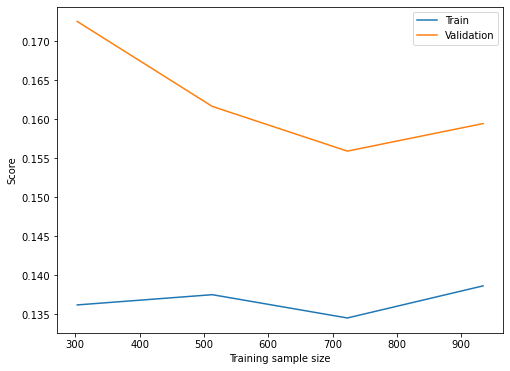

(0.1385872774905177, 0.15946269326325763, 0.013158219326452412)

In [103]:
cross_validate_model(pipe_ridge, train_x_1, train_y_1)

**Filter out features by feature importance**

In [104]:
pipe_ridge.fit(train_x_1, train_y_1)

Pipeline(steps=[('processor',
                 sklearn_pre_processor(cat_to_ord_cols=['ExterQual',
                                                        'ExterCond', 'BsmtQual',
                                                        'BsmtCond', 'HeatingQC',
                                                        'KitchenQual',
                                                        'GarageQual',
                                                        'GarageCond',
                                                        'FireplaceQu'],
                                       drop_cols=['PoolQC', 'MiscFeature',
                                                  'Alley', 'Street',
                                                  'Utilities', 'Condition2',
                                                  'RoofMatl', 'Heating',
                                                  'GarageCond', 'GarageQual',
                                                  'MiscVal', 'KitchenAbvGr',
       

In [105]:
filter_features = FilterFeatures(pipe_ridge['ridge'])

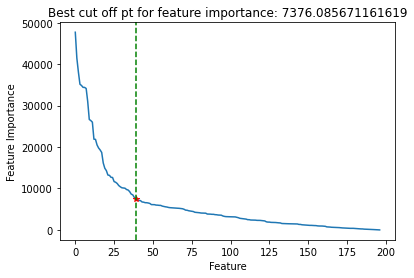

In [106]:
ridge_feat_imp, ridge_elb_pt, ridge_drop_feats= filter_features.get_feature_importance(threshold = 5000)

In [107]:
pipe_ridge = Pipeline([('processor', sklearn_pre_processor(sklearn_columns_drop, cat_to_ord)),
                        ('NumericalScaler', NumericalScaler()),
                     ('OneHotEncode', OneHotEncoder()),
                    ('DropCols', DropCols(ridge_drop_feats)),
                     ('ridge', Ridge(alpha = 15,solver = 'saga' ,random_state = 123))])

Average train score 0.14416320794002335
Average validation score 0.15324530709015538
Validation score stdev 0.011199428506657078
[0.1590177  0.1397064  0.1675936  0.14038938 0.15951946]


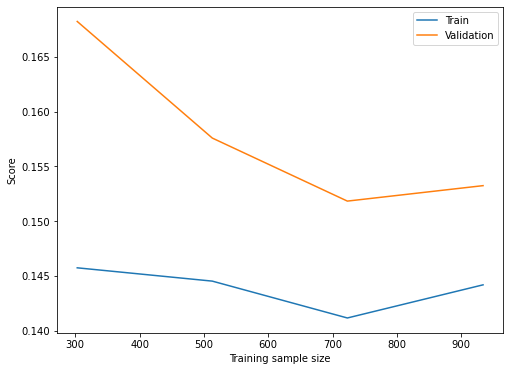

(0.14416320794002335, 0.15324530709015538, 0.011199428506657078)

In [108]:
cross_validate_model(pipe_ridge, train_x_1, train_y_1)

**Grid search for optimal hyper-parameters**

In [109]:
def grid_search_ridge(alpha_list, plot = False, verbose = False):
    num_testings = len(alpha_list)
    alpha = []
    train_mean_lst = []
    val_mean_lst = []
    val_std_lst = []
    print(f'Testing {num_testings} combinations \n')
    for al in alpha_list:
        alpha.append(al)
        if verbose:
            print(f'Model parameters => alpha: {al}')
            print('-'*105)
        pipe_ridge = Pipeline([('processor', sklearn_pre_processor(sklearn_columns_drop, cat_to_ord)),
                              ('NumericalScaler', NumericalScaler()),
                              ('OneHotEncode', OneHotEncoder()),
                              ('DropCols', DropCols(ridge_drop_feats)),
                              ('ridge', Ridge(alpha = al, solver = 'saga' ,random_state = 123))])
        train_mean, val_mean, val_std = cross_validate_model(pipe_ridge, train_x_1, train_y_1, plot = plot, verbose = verbose)
        train_mean_lst.append(train_mean)
        val_mean_lst.append(val_mean)
        val_std_lst.append(val_std)
        if verbose:
            print('='*105, '\n\n')
        else:
            print('=', end = '')
    results_df = pd.DataFrame({'alpha': alpha,
                               'train_mean': train_mean_lst, 'val_mean': val_mean_lst,
                              'val_std': val_std_lst})
    return results_df

In [110]:
grid_ridge_results = grid_search_ridge(np.arange(0, 22, 2))

Testing 11 combinations 


In [111]:
grid_ridge_results.sort_values(by = 'val_mean')

,alpha,train_mean,val_mean,val_std
5,10,0.142476,0.152472,0.012578
4,8,0.142101,0.152612,0.013720
6,12,0.143050,0.152631,0.011826
7,14,0.143768,0.153000,0.011358
3,6,0.142024,0.153233,0.015430
8,16,0.144582,0.153523,0.011085
9,18,0.145468,0.154151,0.010957
2,4,0.142453,0.154691,0.017957
10,20,0.146403,0.154859,0.010930
1,2,0.143838,0.157955,0.021846


**Comments**
- Choose alpha of 12, because it has a low val mean and standard deviation (meanint it is more consistent).

**Fitting the model with optimal hyper-parameters**

In [112]:
 pipe_ridge = Pipeline([('processor', sklearn_pre_processor(sklearn_columns_drop, cat_to_ord)),
                              ('NumericalScaler', NumericalScaler()),
                              ('OneHotEncode', OneHotEncoder()),
                              ('DropCols', DropCols(ridge_drop_feats)),
                              ('ridge', Ridge(alpha = 12, solver = 'saga' ,random_state = 123))])

In [113]:
pipe_ridge.fit(train_x_1, train_y_1)

Pipeline(steps=[('processor',
                 sklearn_pre_processor(cat_to_ord_cols=['ExterQual',
                                                        'ExterCond', 'BsmtQual',
                                                        'BsmtCond', 'HeatingQC',
                                                        'KitchenQual',
                                                        'GarageQual',
                                                        'GarageCond',
                                                        'FireplaceQu'],
                                       drop_cols=['PoolQC', 'MiscFeature',
                                                  'Alley', 'Street',
                                                  'Utilities', 'Condition2',
                                                  'RoofMatl', 'Heating',
                                                  'GarageCond', 'GarageQual',
                                                  'MiscVal', 'KitchenAbvGr',
       

In [114]:
ridge_pred = pipe_ridge.predict(train_x_2)

## RandomForestRegressor <a class = "anchor" id = "rfr"></a>

[Back to top](#backtotop)

**Initial Cross-Validation**

In [115]:
pipe_rfr = Pipeline([('processor', sklearn_pre_processor(sklearn_columns_drop, cat_to_ord)),
                     ('OneHotEncode', OneHotEncoder()),
                     ('rfr', RandomForestRegressor(max_depth = 10, random_state = 123))])

Average train score 0.07120945324153763
Average validation score 0.1519183225743971
Validation score stdev 0.011693500911561247
[0.16492659 0.14357356 0.16648214 0.147198   0.13741131]


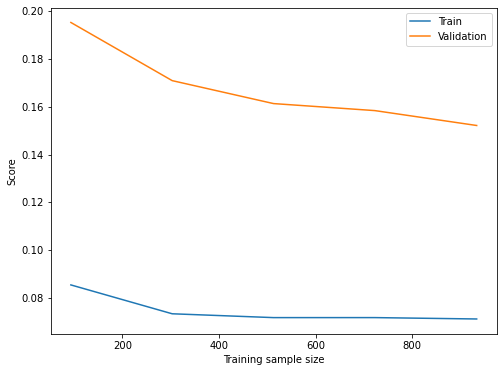

(0.07120945324153763, 0.1519183225743971, 0.011693500911561247)

In [116]:
cross_validate_model(pipe_rfr, train_x_1, train_y_1)

**Filter out features by feature importance**

In [117]:
pipe_rfr.fit(train_x_1, train_y_1)

Pipeline(steps=[('processor',
                 sklearn_pre_processor(cat_to_ord_cols=['ExterQual',
                                                        'ExterCond', 'BsmtQual',
                                                        'BsmtCond', 'HeatingQC',
                                                        'KitchenQual',
                                                        'GarageQual',
                                                        'GarageCond',
                                                        'FireplaceQu'],
                                       drop_cols=['PoolQC', 'MiscFeature',
                                                  'Alley', 'Street',
                                                  'Utilities', 'Condition2',
                                                  'RoofMatl', 'Heating',
                                                  'GarageCond', 'GarageQual',
                                                  'MiscVal', 'KitchenAbvGr',
       

In [118]:
filter_features = FilterFeatures(pipe_rfr['rfr'])

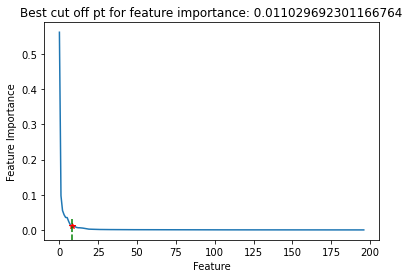

In [119]:
rfr_feature_importance, rfr_thresh, rfr_drop_cols= filter_features.get_feature_importance(threshold = 0.001)

In [120]:
pipe_rfr = Pipeline([('processor', sklearn_pre_processor(sklearn_columns_drop, cat_to_ord)),
                     ('OneHotEncode', OneHotEncoder()),
                     ('DropCols', DropCols(rfr_drop_cols)),
                     ('rfr', RandomForestRegressor(max_depth = 10, random_state = 123))])

Average train score 0.07194759888887657
Average validation score 0.15219696206268998
Validation score stdev 0.010774786824954953
[0.16415549 0.14295628 0.16607946 0.14718116 0.14061242]


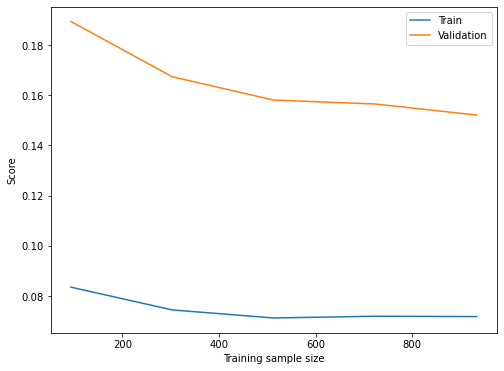

(0.07194759888887657, 0.15219696206268998, 0.010774786824954953)

In [121]:
cross_validate_model(pipe_rfr, train_x_1, train_y_1)

**Comments**
- The model performance is slightly worse, but the results are more consistent.

**Grid search for optimal hyper-parameters**

In [122]:
def rfr_grid_search(n_estimators, max_depth, min_samples_leaf, max_features, plot = False, verbose = False):
    num_testings = len(n_estimators) * len(max_depth) * len(min_samples_leaf) * len(max_features)
    ne = []
    md = []
    msl = []
    mf = []
    train_mean_lst = []
    val_mean_lst = []
    val_std_lst = []
    print(f'Testing {num_testings} combinations \n')
    for n in n_estimators:
        for m in max_depth:
            for l in min_samples_leaf:
                for f in max_features:
                    ne.append(n)
                    md.append(m)
                    msl.append(l)
                    mf.append(f)
                    if verbose:
                        print(f'Model parameters => n_estimators: {n}, max_depth: {m}, min_samples_leaf: {l}, max_features: {f}')
                        print('-'*105)
                    pipe_rfr = Pipeline([('processor', sklearn_pre_processor(sklearn_columns_drop, cat_to_ord)),
                                         ('OneHotEncode', OneHotEncoder()),
                                         ('DropCols', DropCols(rfr_drop_cols)),
                                         ('rfr', RandomForestRegressor(n_estimators = n,
                                                                       max_depth = m,
                                                                       min_samples_leaf = l,
                                                                       max_features = f,
                                                                       random_state = 123))])
                    train_mean, val_mean, val_std = cross_validate_model(pipe_rfr, train_x_1, train_y_1, plot = plot, verbose = verbose)
                    train_mean_lst.append(train_mean)
                    val_mean_lst.append(val_mean)
                    val_std_lst.append(val_std)
                    if verbose:
                        print('='*105, '\n\n')
                    else:
                        print('=', end = '')
    results_df = pd.DataFrame({'n_estimators': ne, 'max_depth': md,
                              'min_samples_leaf':msl, 'max_features': mf,
                               'train_mean': train_mean_lst, 'val_mean': val_mean_lst,
                              'val_std': val_std_lst})
    return results_df

In [123]:
rfr_grid_results = rfr_grid_search(n_estimators = [50, 100, 200],
                max_depth = [5, 10, 20, None], 
                min_samples_leaf = [1, 5, 10, 20], 
                max_features = ['sqrt', 'log2', None])

Testing 144 combinations 


In [124]:
rfr_grid_results.sort_values(by = 'val_mean').head(10)

,n_estimators,max_depth,min_samples_leaf,max_features,train_mean,val_mean,val_std
132,200,NaN,1,sqrt,0.060523,0.147799,0.013621
121,200,20.0,1,log2,0.060914,0.147806,0.013230
120,200,20.0,1,sqrt,0.060425,0.147818,0.012890
72,100,20.0,1,sqrt,0.061223,0.148334,0.013174
84,100,NaN,1,sqrt,0.061512,0.148689,0.013552
133,200,NaN,1,log2,0.060967,0.148850,0.012372
36,50,NaN,1,sqrt,0.063580,0.149512,0.014346
24,50,20.0,1,sqrt,0.063287,0.149528,0.014098
73,100,20.0,1,log2,0.061741,0.149660,0.012672
108,200,10.0,1,sqrt,0.079284,0.149703,0.014234


**Comments**
- When considering which paranmeters to use, it is important to think about model performance as well as the variation (reliability of model performance.
- The parameters that give the lowest validation mean and lowest validation standard deviation will be used: n_estimators = 200, max_depth = 20, min_samples_leaf = 1, max_features = 'sqrt'.

**Fitting the model with optimal hyper-parameters**

In [125]:
pipe_rfr = Pipeline([('processor', sklearn_pre_processor(sklearn_columns_drop, cat_to_ord)),
                                         ('OneHotEncode', OneHotEncoder()),
                                         ('DropCols', DropCols(rfr_drop_cols)),
                                         ('rfr', RandomForestRegressor(n_estimators = 200,
                                                                       max_depth = 20,
                                                                       max_features = 'sqrt',
                                                                       random_state = 123))])

In [126]:
pipe_rfr.fit(train_x_1, train_y_1)

Pipeline(steps=[('processor',
                 sklearn_pre_processor(cat_to_ord_cols=['ExterQual',
                                                        'ExterCond', 'BsmtQual',
                                                        'BsmtCond', 'HeatingQC',
                                                        'KitchenQual',
                                                        'GarageQual',
                                                        'GarageCond',
                                                        'FireplaceQu'],
                                       drop_cols=['PoolQC', 'MiscFeature',
                                                  'Alley', 'Street',
                                                  'Utilities', 'Condition2',
                                                  'RoofMatl', 'Heating',
                                                  'GarageCond', 'GarageQual',
                                                  'MiscVal', 'KitchenAbvGr',
       

In [127]:
rfr_pred = pipe_rfr.predict(train_x_2)

## LightGBM Regressor <a class = "anchor" id = "lgbm"></a>

[Back to top](#backtotop)

In [128]:
lgbm_drop_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Street', 'Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'GarageCond',
                'GarageQual','MiscVal', 'KitchenAbvGr', 'GarageArea', 'FireplaceQu', 'GarageYrBlt']

**Creating a separate pre-processor**

In [129]:
class lgbm_pre_processor(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols):
        self.drop_cols = drop_cols
    
    def fit(self, X, y):
        
        #Defining cols to change
        self.cat_to_ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                                'KitchenQual', 'GarageQual', 'GarageCond', 'FireplaceQu']
        self.cat_to_ordinal_dict = {'Ex':5 , 'Gd':4 , 'TA': 3, 'Fa': 2, 'Po':1, 'NA': -1}

        #Defining category columns based on the training data
        X['MSSubClass'] = X['MSSubClass'].astype(object)
        X['MoSold'] = X['MoSold'].astype(object)
        self.cat_cols = [x for x in X.columns[X.dtypes == 'object'] if x not in self.cat_to_ord_cols]

        #Saving outside space columns
        self.outside_space_cols = [col for col in X.columns if 'Deck' in col or 'Porch' in col]

        #Additional Drop Columns
        self.additional_drop_cols = ([col for col in X.columns if 'Bath' in col] + 
                                     self.outside_space_cols)
        return self
        
    def transform(self, X):
        '''Setting the index'''
        processed_X = X.set_index('Id').copy()
        
        
        #Add columns
        #TotalBath
        processed_X['TotalBath'] = (processed_X.BsmtFullBath + 
                                    0.5*processed_X.BsmtHalfBath +
                                    processed_X.FullBath + 
                                    0.5 * processed_X.HalfBath)

        #Outside Space
        processed_X['outside_space'] = processed_X[self.outside_space_cols].sum(axis = 1)

        #Pool
        processed_X['Pool'] = (processed_X['PoolArea']>0)*1
        self.outside_space_cols += ['PoolArea']
        
        #Reducing Columns
        #Condition1
        processed_X['Condition1'] = processed_X.Condition1.apply(lambda x: 'RR' if 'RR' in x else ('Pos' if 'Pos' in x else x))
        #RoofStyle
        processed_X['RoofStyle'] = processed_X.RoofStyle.apply(lambda x: 'Other' if 'Gable' not in x and 'Hip' not in x else x)
        #Functional
        processed_X['Functional'] = processed_X.Functional.apply(lambda x: 'Other' if x != 'Typ' else x)
        
        #Change data types
        self.cat_cols += ['MSSubClass', 'MoSold', 'YrSold']
        processed_X['MSSubClass'] = processed_X['MSSubClass'].astype(object)
        processed_X['MoSold'] = processed_X['MoSold'].astype(object)
        processed_X['YrSold'] = processed_X['YrSold'].astype(object)
        for col in self.cat_to_ord_cols:
            processed_X[col] = processed_X[col].apply(lambda x: self.cat_to_ordinal_dict[x] if x in self.cat_to_ordinal_dict.keys() else -1)
        for col in self.cat_cols:
            processed_X[col] = processed_X[col].astype('category')
            
        #Drop General Columns
        processed_X.drop(self.drop_cols, axis = 1, inplace = True)
        
        #Drop Additional Columns
        processed_X.drop(self.additional_drop_cols, axis = 1, inplace = True)
        
        return processed_X

**Initial Cross-Validation**

In [130]:
pipe_lgbm = Pipeline([('processor', lgbm_pre_processor(lgbm_drop_cols)),
                     ('lgb', lgb.LGBMRegressor(random_state = 123))])

Average train score 0.04518630432141535
Average validation score 0.1389316836730567
Validation score stdev 0.009907948982158611
[0.15072371 0.12834428 0.15023699 0.13677753 0.12857591]


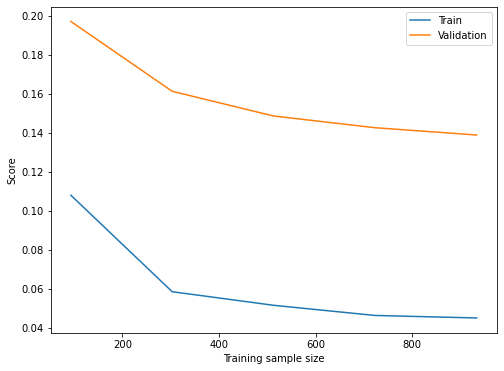

(0.04518630432141535, 0.1389316836730567, 0.009907948982158611)

In [131]:
cross_validate_model(pipe_lgbm, train_x_1, train_y_1)

**Filter out features by feature importance**

In [132]:
pipe_lgbm.fit(train_x_1, train_y_1)

Pipeline(steps=[('processor',
                 lgbm_pre_processor(drop_cols=['PoolQC', 'MiscFeature', 'Alley',
                                               'Street', 'Utilities', 'Street',
                                               'Condition2', 'RoofMatl',
                                               'Heating', 'GarageCond',
                                               'GarageQual', 'MiscVal',
                                               'KitchenAbvGr', 'GarageArea',
                                               'FireplaceQu', 'GarageYrBlt'])),
                ('lgb', LGBMRegressor(random_state=123))])

In [133]:
filter_lgbm = FilterFeatures(pipe_lgbm['lgb'])

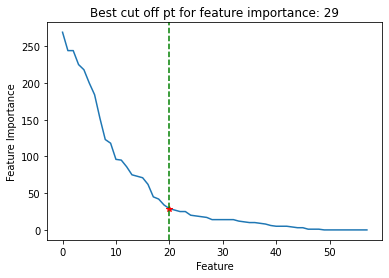

In [134]:
lgb_feature_importance, lgb_thresh, lgb_drop_cols = filter_lgbm.get_feature_importance(threshold = 10)

In [135]:
pipe_lgbm = Pipeline([('processor', lgbm_pre_processor(lgbm_drop_cols)),
                      ('DropCols', DropCols(list(lgb_drop_cols))),
                     ('lgb', lgb.LGBMRegressor(random_state = 123))])

Average train score 0.04655649524526103
Average validation score 0.13970593981147353
Validation score stdev 0.009567555372570978
[0.15152152 0.12896683 0.14995424 0.13814242 0.12994469]


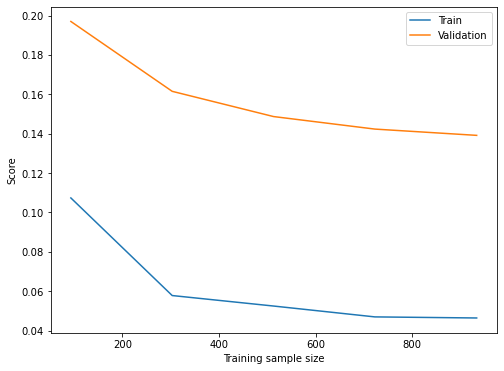

(0.04655649524526103, 0.13970593981147353, 0.009567555372570978)

In [136]:
cross_validate_model(pipe_lgbm, train_x_1, train_y_1)

**Comments**
- Dropping the additional features reduces model performance, but also reduces the variation. We will keep it in the Grid Search as it likely makes the model more consistent.

**Grid search for optimal hyper-parameters**

In [137]:
def lgb_grid_search(num_leaves_lst, min_samples_lst, feature_perc_lst, l1_lst, l2_lst, plot = False, verbose = True):
    num_testings = len(num_leaves_lst) * len(min_samples_lst) * len(feature_perc_lst) * len(l1_lst) * len(l2_lst)
    nll = []
    msl = []
    fpcl = []
    al = []
    bl = []
    train_mean_lst = []
    val_mean_lst = []
    val_std_lst = []
    print(f'Testing {num_testings} combinations \n')
    for l in num_leaves_lst:
        for s in min_samples_lst:
            for f in feature_perc_lst:
                for a in l1_lst:
                    for b in l2_lst:
                        nll.append(l)
                        msl.append(s)
                        fpcl.append(f)
                        al.append(a)
                        bl.append(b)
                        if verbose:
                            print(f'Model parameters => num_leaves: {l}, min_child_samples: {s}, perc_features: {f}, l1: {a}, l2: {b}')
                            print('-'*105)
                        pipe_lgbm = Pipeline([('processor', lgbm_pre_processor(lgbm_drop_cols)),
                                               ('DropCols', DropCols(list(lgb_drop_cols))),
                                              ('lgbm', lgb.LGBMRegressor(num_leaves = l,
                                                                          min_child_samples = s,
                                                                          colsample_bytree = f,
                                                                          reg_alpha = a,
                                                                          reg_lambda = b,
                                                                          random_state = 123))])
                        train_mean, val_mean, val_std = cross_validate_model(pipe_lgbm, train_x_1, train_y_1, plot = plot, verbose = verbose)
                        train_mean_lst.append(train_mean)
                        val_mean_lst.append(val_mean)
                        val_std_lst.append(val_std)
                        if verbose:
                            print('='*105, '\n\n')
                        else:
                            print('=', end = '')
    results_df = pd.DataFrame({'num_leaves': nll, 'min_child_samples': msl,
                              'perc_features':fpcl, 'l1': al, 'l2': bl, 
                               'train_mean': train_mean_lst, 'val_mean': val_mean_lst,
                              'val_std': val_std_lst})
    return results_df

In [138]:
num_leaves = [5, 12, 20]
min_child_samples = [20, 30, 40]
colsample_bytree = [0.5, 0.6, 0.8, 1]
reg_alpha = [0.0]
reg_lambda = [0.0, 0.1, 0.3, 0.5]

In [139]:
results = lgb_grid_search(num_leaves, min_child_samples, colsample_bytree, reg_alpha, reg_lambda, plot = False, verbose = False)

Testing 144 combinations 


In [140]:
results['over_fit'] = results.val_mean - results.train_mean

In [141]:
results.sort_values(by = ['val_mean', 'val_std']).head(20)

,num_leaves,min_child_samples,perc_features,l1,l2,train_mean,val_mean,val_std,over_fit
54,12,20,0.6,0.0,0.3,0.080183,0.133160,0.010973,0.052977
52,12,20,0.6,0.0,0.0,0.079666,0.133822,0.009790,0.054156
71,12,30,0.6,0.0,0.5,0.083191,0.133969,0.011331,0.050778
55,12,20,0.6,0.0,0.5,0.079929,0.134400,0.009167,0.054471
53,12,20,0.6,0.0,0.1,0.079525,0.134576,0.009841,0.055051
97,20,20,0.5,0.0,0.1,0.063038,0.134626,0.009614,0.071588
60,12,20,1.0,0.0,0.0,0.078027,0.134634,0.010435,0.056608
50,12,20,0.5,0.0,0.3,0.081211,0.134741,0.010486,0.053530
101,20,20,0.6,0.0,0.1,0.061143,0.134875,0.008844,0.073732
96,20,20,0.5,0.0,0.0,0.062245,0.134932,0.009494,0.072687


**Comments**
- The lowest val mean/stdev and overfit is when the parameters are: [num_leaves = 12, min_child_samples = 20,
perc_features = 0.6, l2 = 0.5]

**Fitting the model with optimal hyper-parameters**

In [142]:
pipe_lgbm = Pipeline([('processor', lgbm_pre_processor(lgbm_drop_cols)),
                    ('lgbm', lgb.LGBMRegressor(num_leaves = 12,
                                              min_child_samples = 20,
                                              colsample_bytree = 0.6,
                                              reg_alpha = 0,
                                              reg_lambda = 0.5,
                                              random_state = 123))])

Average train score 0.07821477392845205
Average validation score 0.1352870542359233
Validation score stdev 0.011269346358894686
[0.1443786  0.12097571 0.14809435 0.14028843 0.12269819]


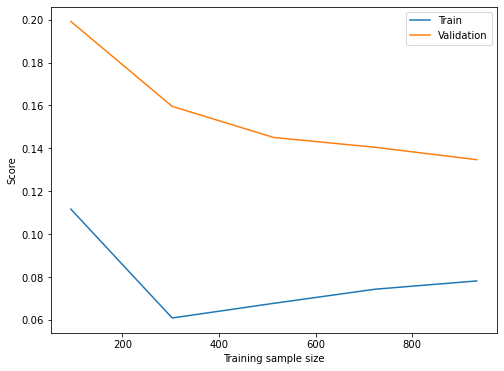

(0.07821477392845205, 0.1352870542359233, 0.011269346358894686)

In [143]:
cross_validate_model(pipe_lgbm, train_x_1, train_y_1)

In [144]:
pipe_lgbm.fit(train_x_1, train_y_1)

Pipeline(steps=[('processor',
                 lgbm_pre_processor(drop_cols=['PoolQC', 'MiscFeature', 'Alley',
                                               'Street', 'Utilities', 'Street',
                                               'Condition2', 'RoofMatl',
                                               'Heating', 'GarageCond',
                                               'GarageQual', 'MiscVal',
                                               'KitchenAbvGr', 'GarageArea',
                                               'FireplaceQu', 'GarageYrBlt'])),
                ('lgbm',
                 LGBMRegressor(colsample_bytree=0.6, num_leaves=12,
                               random_state=123, reg_alpha=0,
                               reg_lambda=0.5))])

In [145]:
lgb_pred = pipe_lgbm.predict(train_x_2)

- The model has a harder time predicting middle range home values.

# Stacking Models <a class = "anchor" id = "stacking"></a>

[Back to top](#backtotop)

In [146]:
train_2 = np.stack([ridge_pred, rfr_pred, lgb_pred], axis = 1)

In [147]:
train_2 = pd.DataFrame(train_2, columns = ['ridge_pred', 'rfr_pred', 'lgb_pred'])

In [148]:
model2 = Pipeline([('NumericalScaler', NumericalScaler()),
                     ('ridge', Ridge(solver = 'saga', random_state = 123))])

Average train score 0.10843753404979968
Average validation score 0.10755559446240673
Validation score stdev 0.02061960168663357
[0.1149096  0.09565822 0.11795611 0.07458632 0.13466772]


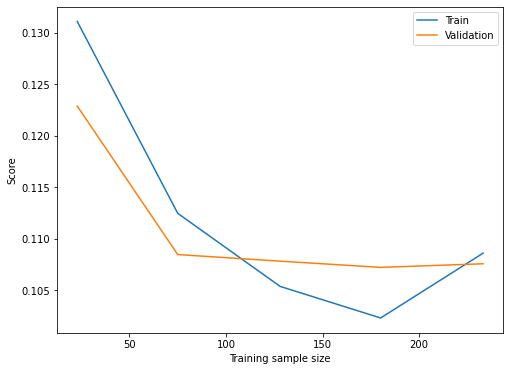

(0.10843753404979968, 0.10755559446240673, 0.02061960168663357)

In [149]:
cross_validate_model(model2, train_2, train_y_2)

In [150]:
model2.fit(train_2, train_y_2)

Pipeline(steps=[('NumericalScaler', NumericalScaler()),
                ('ridge', Ridge(random_state=123, solver='saga'))])

# Test Set <a class = "anchor" id = "test"></a>

[Back to top](#backtotop)

In [151]:
test_x = pd.read_csv(DATA_PATH + 'test.csv')

In [152]:
ridge_test = pipe_ridge.predict(test_x)

In [153]:
rfr_test = pipe_rfr.predict(test_x)

In [154]:
lgb_test = pipe_lgbm.predict(test_x)

In [155]:
test_x_1 = pd.DataFrame(np.stack([ridge_test, rfr_test, lgb_test], axis = 1), columns = ['ridge_pred', 'rfr_pred', 'lgb_pred'])

In [156]:
y_test_pred = model2.predict(test_x_1)

In [157]:
# y_test_pred = pipe_lgbm.predict(test_x)

In [158]:
predictions_df = pd.DataFrame(y_test_pred, index = test_x.Id)

In [159]:
predictions_df.columns = ['SalePrice']

In [160]:
predictions_df.to_csv(DATA_PATH + 'predictions.csv')

In [161]:
predictions_df

,SalePrice
Id,
1461,113469.658901
1462,159270.146073
1463,178860.518404
1464,190721.880306
1465,193997.297366
...,...
2915,73628.243245
2916,77666.467154
2917,166662.275830
